In [0]:
import numpy as np
import torch
import seaborn
seaborn.set(style='darkgrid')
def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]
def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
    [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

In [0]:
a = sample_data_1()

In [0]:
b =sample_data_2()

In [0]:
import matplotlib.pyplot as plt


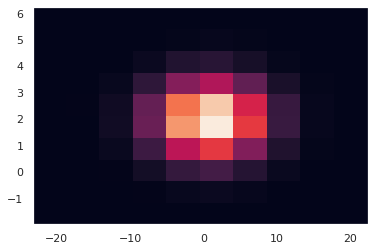

In [0]:
plt.hist2d(a[:,0],a[:,1])
plt.show()

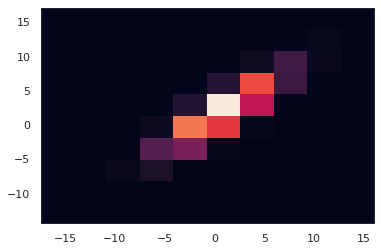

In [0]:
plt.hist2d(b[:,0],b[:,1])
plt.show()

In [0]:
def UnitTransform(x):
    pos_only = (x - x.min(axis=0))
    units = (pos_only.max(axis=0)- pos_only)/(pos_only.max(axis=0))
    return units
    

In [0]:
#UnitTransform(b)

In [0]:
class DataSet:

    def __init__(self,X):
        """Init function should not do any heavy lifting, but
            must initialize how many items are available in this data set.
        """
        
        self.images = X

    def __len__(self):
        """return number of points in our dataset"""

        return len(self.images)

    def __getitem__(self, idx):
        """ Here we have to return the item requested by `idx`
            The PyTorch DataLoader class will use this method to make an iterable for
            our training or validation loop.
        """

        img = self.images[idx]

        return img

In [0]:
a_new = torch.FloatTensor(a)#UnitTransform(a)
b_new = torch.FloatTensor(b)#UnitTransform(b)
data_a_train = DataSet(torch.FloatTensor(a_new[0:int(0.8*len(a))]))
data_a_val = DataSet(torch.FloatTensor(a_new[int(0.8*len(a)):int(0.9*len(a))]))
data_a_test = DataSet(torch.FloatTensor(a_new[int(0.9*len(a)):]))
data_b_train = DataSet(torch.FloatTensor(b_new[0:int(0.8*len(b))]))
data_b_val = DataSet(torch.FloatTensor(b_new[int(0.8*len(b)):int(0.9*len(b))]))
data_b_test = DataSet(torch.FloatTensor(a_new[int(0.9*len(a)):]))


In [0]:
class DeterministicWarmup(object):
    """
    Linear deterministic warm-up as described in
    [Sønderby 2016].
    """
    def __init__(self, start_epochs=0, max_epochs=100, t_max=1):
        self.t = 0
        self.t_max = t_max
        self.inc = 1/max_epochs
        self.start_epochs=start_epochs

    def __iter__(self):
        return self

    def __next__(self, epoch):
        if epoch>=self.start_epochs:
            t = self.t + self.inc
            self.start_epochs +=1
            self.t = self.t_max if t > self.t_max else t
        return self.t

In [0]:
import torch
import torch.nn as nn
from torch.nn.functional import softplus
from torch import optim
import torch.nn.functional as F

# define size variables
num_features = 2

#def warmup(epoch, start=5, end=25):
#    factor = min((epoch-start)/(end-start),1)
#    return max(factor,0)

warmup = DeterministicWarmup(max_epochs=25)

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_features, num_samples, scalar, beta=warmup ):
        super(VariationalAutoencoder, self).__init__()
        
        self.latent_features = latent_features
        self.num_samples = num_samples
        self.scalar = scalar
        self.beta = beta
        self.out_features = self.latent_features+1  if self.scalar else 2*self.latent_features

        # We encode the data onto the latent space using two linear layers
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=32),
            nn.ELU(),
            nn.Linear(in_features=32, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=(self.latent_features*2))
        )
        
        # The latent code must be decoded into the original image
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.latent_features, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=32),
            nn.ELU(),
            nn.Linear(in_features=32, out_features=self.out_features)
        )
        

    def forward(self, x): 
        outputs = {}
        
        # Split encoder outputs into a mean and variance vector      
        mu, log_var = torch.chunk(self.encoder(x), 2, dim=-1)

        # :- Reparametrisation trick
        z = self.Reparametrisation(mu,log_var)  

        # Run through decoder and sample reconstruction
        x_sample = self.decoder(z)

        if self.scalar:
            x_mu, x_log_var = torch.split(x_sample, self.latent_features, dim=-1)
            x_log_var = torch.ones_like(x_mu)*x_log_var
        else:
            x_mu, x_log_var = torch.chunk(x_sample, 2, dim=-1)
        
        outputs["x_hat"] = self.Reparametrisation(x_mu,x_log_var)  
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        outputs["x_mu"] = x_mu
        outputs["x_log_var"] = x_log_var

        return outputs

    def Reparametrisation(self,mu, log_var):
        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)

        # Don't propagate gradients through randomness
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def sample(self, z):
        """
        Given z ~ N(0, I) generates a sample from
        the learned distribution based on p_θ(x|z).
        :param z: (torch.autograd.Variable) Random normal variable
        :return: (torch.autograd.Variable) generated sample
        """
        x_sample = self.decoder(z)
        x_mu, x_log_var = torch.chunk(x_sample, 2, dim=-1)
        full_generation_path = self.Reparametrisation(x_mu,x_log_var)  
        without_decoder_noise = x_mu
        return full_generation_path, without_decoder_noise

    def loss_function(self, t, mu, log_var, x_mu,x_log_var, epoch):
        # Reconstruction error, log[p(x|z)]
        # Sum over features
        
        #likelihood = F.mse_loss(y,t,reduction='none')
        #likelihood = likelihood.view(likelihood.size(0),-1).sum(1)
        likelihood = torch.sum(-log_normal(t,x_mu,x_log_var),dim=1)


        # Regularization error: 
        # Kulback-Leibler divergence between approximate posterior, q(z|x)
        # and prior p(z) = N(z | mu, sigma*I).
        
        # In the case of the KL-divergence between diagonal covariance Gaussian and 
        # a standard Gaussian, an analytic solution exists. Using this excerts a lower
        # variance estimator of KL(q||p)
        kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)

        # Combining the two terms in the evidence lower bound objective (ELBO) 
        # mean over batch
        nll = torch.mean(likelihood)/np.log(2)/2
        kl = torch.mean(kl)
        self.beta.__next__(epoch)
        ELBO = nll + self.beta.t*kl
        
        # notice minus sign as we want to maximise ELBO
        return ELBO, kl, nll

def log_normal(x, mean, log_var, eps=1e-5):
    c = - 0.5 * np.log(2*np.pi)
    return c - log_var/2 - (x - mean)**2 / (2 * torch.exp(log_var) + eps)

In [0]:
latent_features =2
num_samples = 10
scalar = False
net = VariationalAutoencoder(latent_features, num_samples, scalar)

print(net)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=4, bias=True)
  )
)


In [0]:
# define our optimizer
# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

In [0]:
#a_new = UnitTransform(a)

x = a_new[0:1000]
outputs = net(x)

mu, log_var = outputs["mu"], outputs["log_var"]
x_mu, x_log_var = outputs["mu"], outputs["log_var"]
z = outputs["z"]

#print(x.shape)
#print(x_log_var.shape)
#print(x_mu.shape)

loss,kl,nll = net.loss_function(x, mu, log_var,x_mu,x_log_var, 1)

print(loss)


tensor(14.6279, grad_fn=<AddBackward0>)


In [0]:
def fit(data_a_train, data_a_val, data_a_test, epochs=50):

    losses, val_losses =[],[]
    batch_size = 1000

    train_iter = torch.utils.data.DataLoader(dataset=data_a_train,batch_size=batch_size,shuffle=True)
    val_iter = torch.utils.data.DataLoader(dataset=data_a_val,batch_size=batch_size,shuffle=True)
    test_iter = torch.utils.data.DataLoader(dataset=data_a_test,batch_size=batch_size,shuffle=True)


    losses = []
    val_losses = []
    kls = []
    val_kls = []
    nlls = []
    val_nlls = []

    for epoch in range(epochs):

        loss = 0
        
        for train_X in train_iter:
            
            outputs = net(train_X)
            
            x_hat = outputs["x_hat"]
            mu, log_var = outputs["mu"], outputs["log_var"]
            x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
            
            loss, kl, nll = net.loss_function(train_X, mu, log_var,x_mu, x_log_var, epoch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.data.numpy())
            kls.append(kl.data.numpy())
            nlls.append(nll.data.numpy())

            
        with torch.set_grad_enabled(False):

            for val_X in val_iter:
                
                outputs = net(val_X)

                x_hat = outputs["x_hat"]
                mu, log_var = outputs["mu"], outputs["log_var"]
                x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
                z = outputs["z"]

                val_loss, val_kl, val_nll = net.loss_function(val_X, mu, log_var, x_mu, x_log_var, epoch)

                val_losses.append(val_loss.data.numpy())
                val_kls.append(val_kl.data.numpy())
                val_nlls.append(val_nll.data.numpy())

        if epoch % 10 ==0:
            print('Epoch {}: loss {} kl {} nll {} '.format(epoch,loss.item(),kl.item(),nll.item()))

    test_losses = []
    test_kls = []
    test_nlls = []
    for test_X in test_iter:
    
        outputs = net(test_X)

        x_hat = outputs["x_hat"]
        mu, log_var = outputs["mu"], outputs["log_var"]
        x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
        z = outputs["z"]

        test_loss, test_kl, test_nll = net.loss_function(test_X, mu, log_var, x_mu, x_log_var, epoch)

        test_losses.append(test_loss.data.numpy())
        test_kls.append(test_kl.data.numpy())
        test_nlls.append(test_nll.data.numpy())

    print('test loss {}  test kl {} test nll {} '.format(np.mean(test_losses),np.mean(test_kls),np.mean(test_nlls)))
    import matplotlib.pyplot as plt
    f, axarr = plt.subplots(1,3, figsize=(18,6))

    ax = axarr[0]
    ax.set_title('ELBO')
    ax.plot(losses, label = "ELBO_train_loss")
    ax.plot(np.arange(0, len(losses),(len(losses)/len(val_losses))),val_losses, label = "ELBO_val_loss")

    ax = axarr[1]
    ax.set_title('KL')
    ax.plot(kls, label = "kl_train_loss")
    ax.plot(np.arange(0, len(kls),(len(kls)/len(val_kls))),val_kls, label = "KL_val_loss")

    ax = axarr[2]
    ax.set_title('NLL')
    ax.plot(nlls, label = "NLL_train_loss")
    ax.plot(np.arange(0, len(nlls),(len(nlls)/len(val_nlls))),val_nlls, label = "NLL_val_loss")
    plt.show()


In [0]:
def plotter(a_new):
    f, axarr = plt.subplots(2,2, figsize=(14,8))

    net.eval()
    z = torch.randn(1000, 2)
    full_generation_path, without_decoder_noise = net.sample(z)
    full_generation_path = full_generation_path.data.numpy() 
    without_decoder_noise = without_decoder_noise.data.numpy()
    x_rec = net.forward(a_new[0:1000])['x_hat'].data.numpy()
    
    ax = axarr[0][0]
    ax.set_title('Reconstruced samples')
    ax.scatter(a_new[:1000,0].data.numpy(),a_new[:1000,1].data.numpy())
    ax.scatter(x_rec[:,0],x_rec[:,1])
    ax.axis('equal')

    ax = axarr[0][1]
    ax.set_title('latent space')
    ax.scatter(z[:,0].data.numpy(),z[:,1].data.numpy())
    ax.axis('equal')

    ax = axarr[1][0]
    ax.scatter(a_new[:1000,0].data.numpy(),a_new[:1000,1].data.numpy())
    ax.scatter(full_generation_path[:,0],full_generation_path[:,1])
    ax.set_title('samples using full generation path from latent space')
    ax.axis('equal')

    ax = axarr[1][1]
    ax.scatter(a_new[:1000,0].data.numpy(),a_new[:1000,1].data.numpy())
    ax.scatter(without_decoder_noise[:,0],without_decoder_noise[:,1])
    ax.set_title('samples without decoder noise from latent space')
    ax.axis('equal')
    plt.show()


Epoch 0: loss 3.3872337341308594 kl 4.273799896240234 nll 3.2162816524505615 
Epoch 10: loss 2.625509738922119 kl 3.2126107215881348 nll 1.2119609117507935 
Epoch 20: loss 3.58341121673584 kl 2.360269069671631 nll 1.600785255432129 
Epoch 30: loss 3.300036907196045 kl 0.2535523474216461 nll 3.0464844703674316 
Epoch 40: loss 3.2842652797698975 kl 0.0716298297047615 nll 3.2126355171203613 
test loss 3.2225241661071777  test kl 0.020459841936826706 test nll 3.2020645141601562 


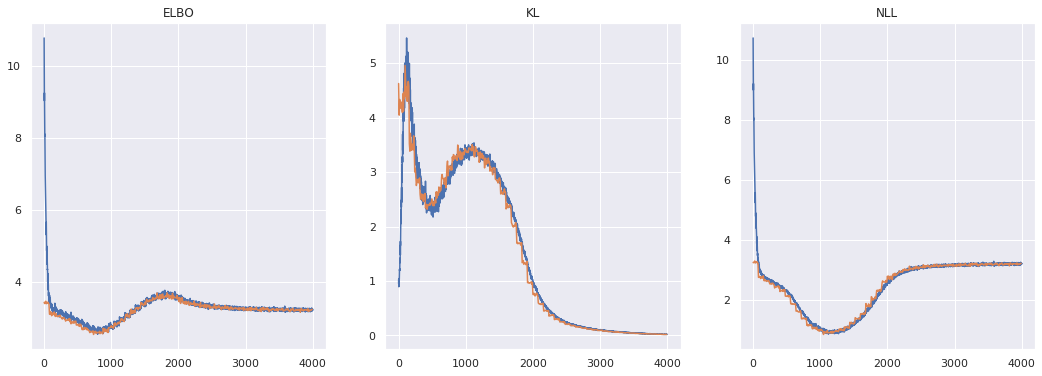

In [0]:
warmup = DeterministicWarmup(max_epochs=25)
net = VariationalAutoencoder(latent_features, num_samples, scalar,beta=warmup)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
fit(data_a_train, data_a_val, data_a_test)

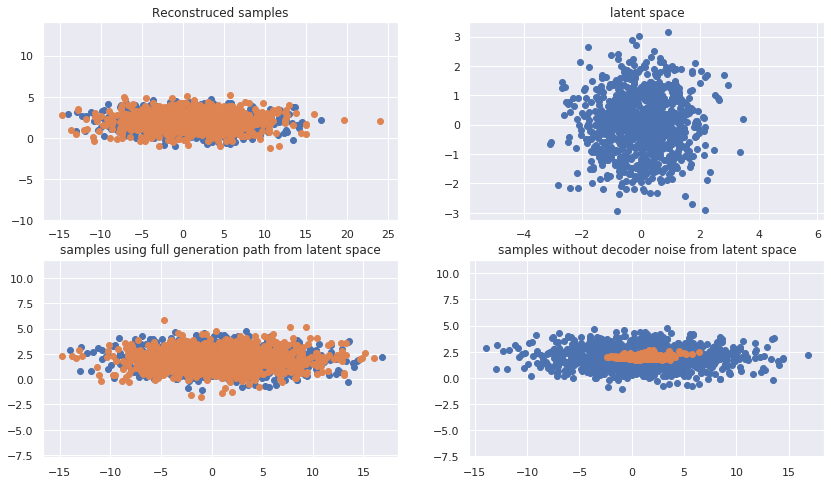

In [0]:
plotter(a_new)

Epoch 0: loss 4.113303184509277 kl 7.186642646789551 nll 3.8258373737335205 
Epoch 10: loss 2.61409330368042 kl 3.593202829360962 nll 1.0330839157104492 
Epoch 20: loss 3.5842366218566895 kl 2.2357988357543945 nll 1.7061657905578613 
Epoch 30: loss 3.6279516220092773 kl 1.2750290632247925 nll 2.3529224395751953 
Epoch 40: loss 3.6202192306518555 kl 1.216488242149353 nll 2.403731107711792 
test loss 3.606257200241089  test kl 1.2182252407073975 test nll 2.3880324363708496 


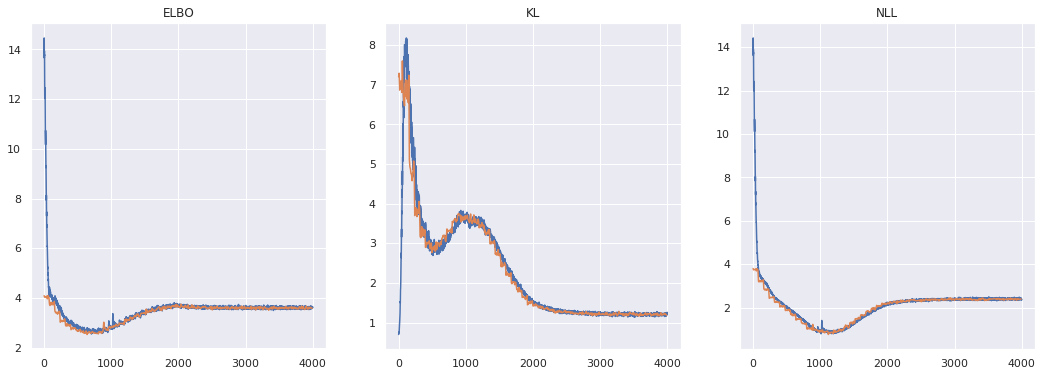

In [0]:
#using scalar
warmup = DeterministicWarmup(max_epochs=25)
net = VariationalAutoencoder(latent_features, num_samples, True,beta=warmup)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
fit(data_a_train, data_a_val, data_a_test)

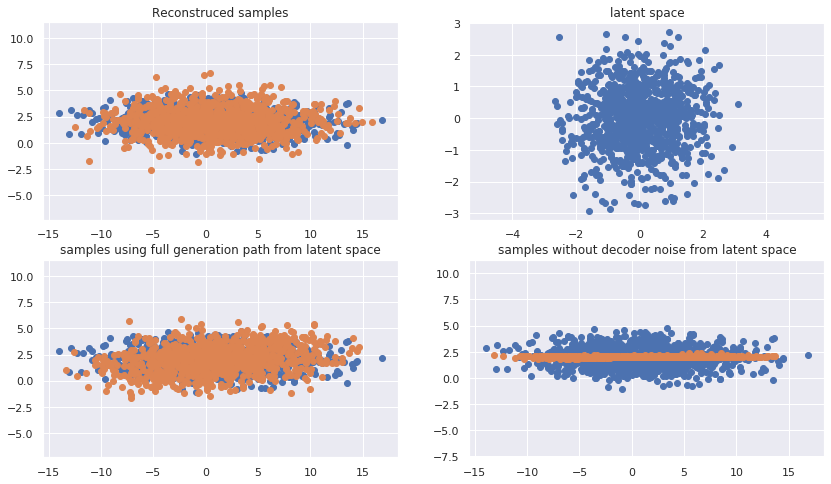

In [0]:
plotter(a_new)

In [0]:
#new dataset

Epoch 0: loss 6.721558094024658 kl 1.8557660579681396 nll 6.647327423095703 
Epoch 10: loss 3.106354236602783 kl 2.0634355545043945 nll 2.1984426975250244 
Epoch 20: loss 3.4109599590301514 kl 1.4012765884399414 nll 2.2338876724243164 
Epoch 30: loss 3.5662879943847656 kl 1.2056199312210083 nll 2.3606679439544678 
Epoch 40: loss 3.58884859085083 kl 1.1789857149124146 nll 2.409862756729126 
test loss 6.179744720458984  test kl 1.114964485168457 test nll 5.064780235290527 


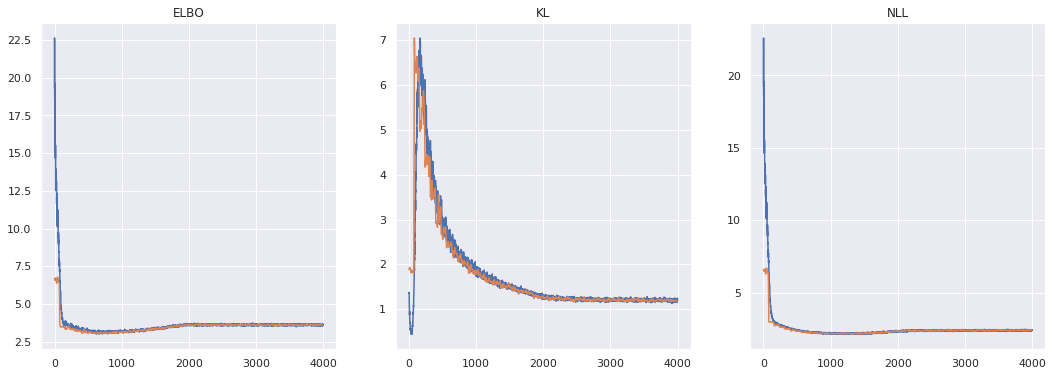

In [0]:
#not using scalar
warmup = DeterministicWarmup(max_epochs=25)
net = VariationalAutoencoder(latent_features, num_samples, scalar, beta=warmup)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
fit(data_b_train, data_b_val, data_b_test)

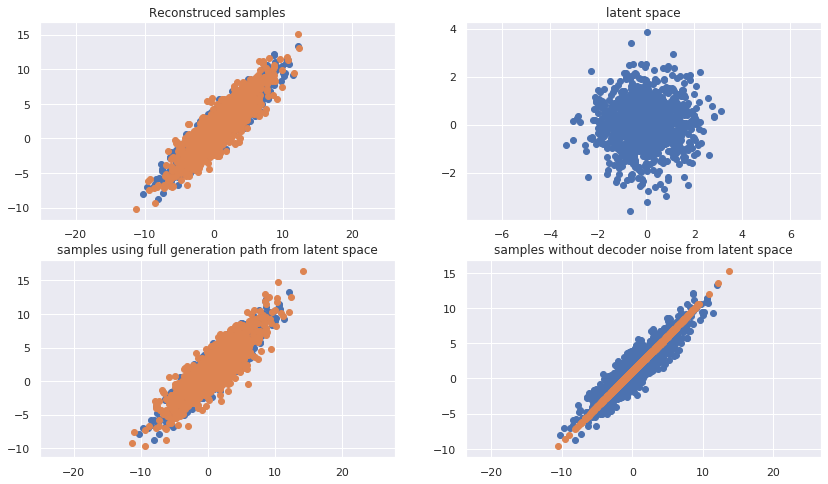

In [0]:
plotter(b_new)

Epoch 0: loss 7.1751885414123535 kl 2.433288812637329 nll 7.07785701751709 
Epoch 10: loss 4.117212772369385 kl 2.8917791843414307 nll 2.84483003616333 
Epoch 20: loss 3.8737316131591797 kl 1.4073501825332642 nll 2.6915576457977295 
Epoch 30: loss 3.7178194522857666 kl 0.9417779445648193 nll 2.7760415077209473 
Epoch 40: loss 3.6231460571289062 kl 1.0498274564743042 nll 2.5733187198638916 
test loss 5.983201503753662  test kl 1.1615499258041382 test nll 4.821651458740234 


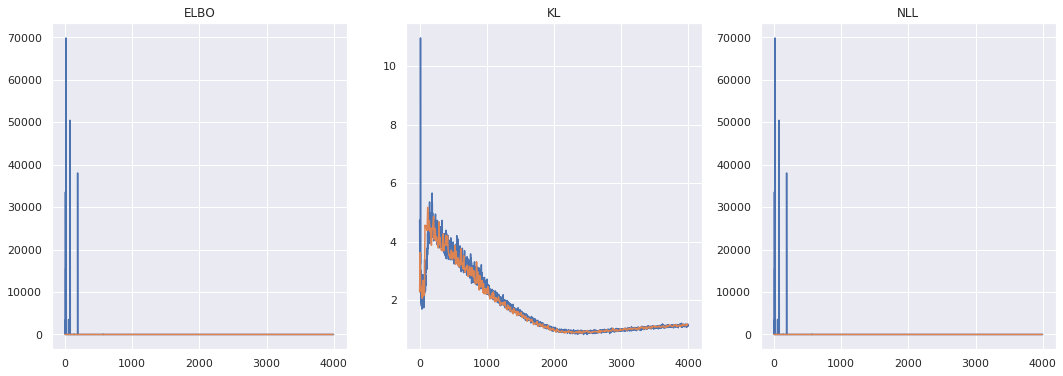

In [0]:
# Using scalar
warmup = DeterministicWarmup(max_epochs=25)
net = VariationalAutoencoder(latent_features, num_samples, True, beta=warmup)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
fit(data_b_train, data_b_val, data_b_test)

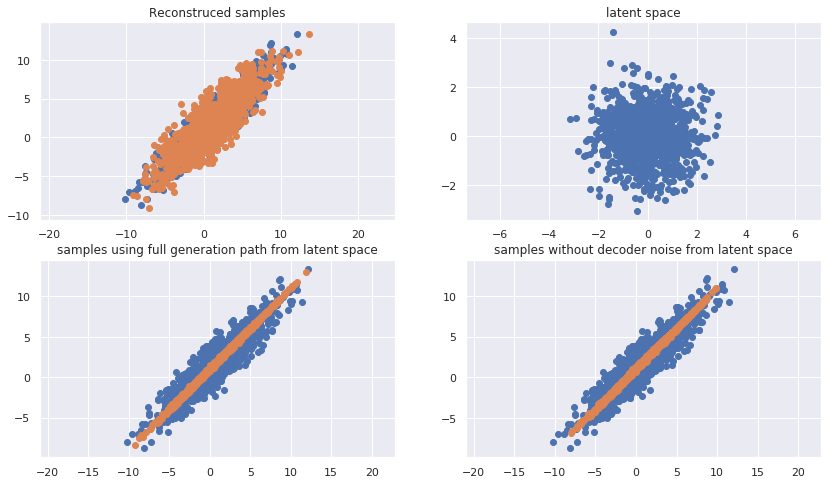

In [0]:
plotter(b_new)

# PART 2


In [0]:
import numpy as np
def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

In [0]:
c, y = sample_data_3()
c_new = torch.FloatTensor(c)#UnitTransform(a)
data_c_train = DataSet(torch.FloatTensor(c_new[0:int(0.8*len(c))]))
data_c_val = DataSet(torch.FloatTensor(c_new[int(0.8*len(c)):int(0.9*len(c))]))
data_c_test = DataSet(torch.FloatTensor(c_new[int(0.9*len(c)):]))


(-5, 5, -5, 5)

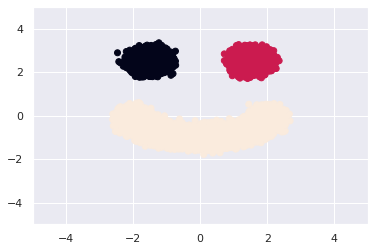

In [0]:
plt.figure()
plt.scatter(c[:,0], c[:,1], c=y)
plt.axis((-5,5,-5,5))

In [0]:
def fit(data_a_train, data_a_val, data_a_test, epochs=50):

    losses, val_losses =[],[]
    batch_size = 1000

    train_iter = torch.utils.data.DataLoader(dataset=data_a_train,batch_size=batch_size,shuffle=True)
    val_iter = torch.utils.data.DataLoader(dataset=data_a_val,batch_size=batch_size,shuffle=True)
    test_iter = torch.utils.data.DataLoader(dataset=data_a_test,batch_size=batch_size,shuffle=True)


    losses = []
    val_losses = []
    val_losses100 = []
    kls = []
    val_kls = []
    val_kls100 = []
    nlls = []
    val_nlls = []
    val_nlls100 = []

    for epoch in range(epochs):
        net.num_samples=1
        net.train()

        loss = 0
        
        for train_X in train_iter:
            
            outputs = net(train_X)
            
            x_hat = outputs["x_hat"]
            mu, log_var = outputs["mu"], outputs["log_var"]
            x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
            z = outputs["z"]
            
            loss, kl, nll = net.loss_function(train_X, mu, log_var,x_mu, x_log_var,z, epoch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.data.numpy())
            kls.append(kl.data.numpy())
            nlls.append(nll.data.numpy())

            
        with torch.set_grad_enabled(False):
            net.eval()

            for val_X in val_iter:
                
                outputs = net(val_X)

                x_hat = outputs["x_hat"]
                mu, log_var = outputs["mu"], outputs["log_var"]
                x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
                z = outputs["z"]

                val_loss, val_kl, val_nll = net.loss_function(val_X, mu, log_var, x_mu, x_log_var, z, epoch)

                val_losses.append(val_loss.data.numpy())
                val_kls.append(val_kl.data.numpy())
                val_nlls.append(val_nll.data.numpy())

        with torch.set_grad_enabled(False):
            net.num_samples=100
            net.eval()

            for val_X in val_iter:
                
                outputs = net(val_X)

                x_hat = outputs["x_hat"]
                mu, log_var = outputs["mu"], outputs["log_var"]
                x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
                z = outputs["z"]

                val_loss, val_kl, val_nll = net.loss_function(val_X, mu, log_var, x_mu, x_log_var, z, epoch)

                val_losses100.append(val_loss.data.numpy())
                val_kls100.append(val_kl.data.numpy())
                val_nlls100.append(val_nll.data.numpy())

        if epoch % 10 ==0:
            print('Epoch {}: loss {} kl {} nll {} '.format(epoch,loss.item(),kl.item(),nll.item()))

    test_losses = []
    test_kls = []
    test_nlls = []
    for test_X in test_iter:
    
        outputs = net(test_X)

        x_hat = outputs["x_hat"]
        mu, log_var = outputs["mu"], outputs["log_var"]
        x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
        z = outputs["z"]

        test_loss, test_kl, test_nll = net.loss_function(test_X, mu, log_var, x_mu, x_log_var, z, epoch)

        test_losses.append(test_loss.data.numpy())
        test_kls.append(test_kl.data.numpy())
        test_nlls.append(test_nll.data.numpy())


    print('test loss {}  test kl {} test nll {} '.format(np.mean(test_losses),np.mean(test_kls),np.mean(test_nlls)))
    import matplotlib.pyplot as plt
    f, axarr = plt.subplots(1,3, figsize=(18,6))

    ax = axarr[0]
    ax.set_title('ELBO')
    ax.plot(losses, label = "ELBO_train_loss")
    ax.plot(np.arange(0, len(losses),(len(losses)/len(val_losses))),val_losses, label = "ELBO_val_loss")

    ax = axarr[1]
    ax.set_title('KL')
    ax.plot(kls, label = "kl_train_loss")
    ax.plot(np.arange(0, len(kls),(len(kls)/len(val_kls))),val_kls, label = "KL_val_loss")

    ax = axarr[2]
    ax.set_title('NLL')
    ax.plot(nlls, label = "NLL_train_loss")
    ax.plot(np.arange(0, len(nlls),(len(nlls)/len(val_nlls))),val_nlls, label = "NLL_val_loss")
    plt.show()

    import matplotlib.pyplot as plt
    f, ax = plt.subplots(1,1, figsize=(9,6))

    ax.set_title('ELBO')
    ax.plot(losses, label = "ELBO_train_loss")
    ax.plot(np.arange(0, len(losses),(len(losses)/len(val_losses))),val_losses, label = "IWAE 1")
    ax.plot(np.arange(0, len(losses),(len(losses)/len(val_losses100))),val_losses100, label = "IWAE 100")
    plt.show()


In [0]:
import torch
import torch.nn as nn
from torch.nn.functional import softplus
from torch import optim
import torch.nn.functional as F

# define size variables
num_features = 2
latent_features=2
num_samples=1
scalar = False
epochs=1000

warmup = DeterministicWarmup(max_epochs=25)

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_features, num_samples, scalar, beta=warmup ):
        super(VariationalAutoencoder, self).__init__()
        
        self.latent_features = latent_features
        self.num_samples = num_samples
        self.scalar = scalar
        self.beta = beta
        self.out_features = self.latent_features+1  if self.scalar else 2*self.latent_features

        # We encode the data onto the latent space using two linear layers
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=(self.latent_features*2))
        )
        
        # The latent code must be decoded into the original image
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=self.out_features)
        )
        

    def forward(self, x): 
        outputs = {}
        
        # Split encoder outputs into a mean and variance vector      
        q_mu, q_log_var = torch.chunk(self.encoder(x), 2, dim=-1)
        q_mu = q_mu.unsqueeze(1)
        q_log_var = q_log_var.unsqueeze(1)

        # :- Reparametrisation trick
        z = self.Reparametrisation(q_mu,q_log_var,self.num_samples)  


        # Run through decoder and sample reconstruction
        x_sample = self.decoder(z)

        # split in 2 parts
        x_mu, x_log_var = torch.chunk(x_sample, 2, dim=-1)
        outputs["x_hat"] = self.Reparametrisation(x_mu,x_log_var,1)  
        outputs["z"] = z
        outputs["mu"] =q_mu
        outputs["log_var"] = q_log_var
        outputs["x_mu"] = x_mu
        outputs["x_log_var"] = x_log_var

        return outputs

    def Reparametrisation(self,mu, log_var, num_samples):
        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)

        # Don't propagate gradients through randomness
        
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, num_samples, self.latent_features)

        sigma = torch.exp(0.5*log_var)
        
        # We will need to unsqueeze to turn
        # (batch_size, latent_dim) -> (batch_size, 1, latent_dim)
        if len(mu.shape)<3:
            z = mu.unsqueeze(1) + epsilon * sigma.unsqueeze(1)  
        else:
            z = mu + epsilon * sigma  

        return z
    
    def sample(self, z):
        """
        Given z ~ N(0, I) generates a sample from
        the learned distribution based on p_θ(x|z).
        :param z: (torch.autograd.Variable) Random normal variable
        :return: (torch.autograd.Variable) generated sample
        """
        if len(z.shape)<3:
            z = z.unsqueeze(1)
        x_sample = self.decoder(z)
        x_mu, x_log_var = torch.chunk(x_sample, 2, dim=-1)
        full_generation_path = self.Reparametrisation(x_mu,x_log_var,1)  
        without_decoder_noise = x_mu
        return full_generation_path, without_decoder_noise

    def loss_function(self, t, q_mu, q_log_var, x_mu, x_log_var, z, epoch):
        # Reconstruction error, log[p(x|z)]
        # Sum over features
        t = t.unsqueeze(1)

        #likelihood = F.mse_loss(y,t,reduction='none')
        #likelihood = likelihood.view(likelihood.size(0),-1).sum(1)
        #log_pxz = log_normal, rec loss
        likelihood = torch.mean(torch.sum(-log_normal(t,x_mu,x_log_var),dim=2),dim=1)
        # regularization error:
        p_mu, p_log_var = torch.zeros_like(q_mu), torch.ones_like(q_log_var)

        log_qz = log_normal(z, q_mu, q_log_var)
        log_pz = log_normal(z, p_mu, p_log_var)
        kl = torch.mean(torch.sum(log_qz - log_pz,dim=2),dim=1)

        # Regularization error: 
        # Kulback-Leibler divergence between approximate posterior, q(z|x)
        # and prior p(z) = N(z | mu, sigma*I).
        
        # In the case of the KL-divergence between diagonal covariance Gaussian and 
        # a standard Gaussian, an analytic solution exists. Using this excerts a lower
        # variance estimator of KL(q||p)
        #kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)

        # Combining the two terms in the evidence lower bound objective (ELBO) 
        # mean over batch
        nll = torch.mean(likelihood)/np.log(2)/2
        kl = torch.mean(kl)/np.log(2)/2
        self.beta.__next__(epoch)
        ELBO = nll + self.beta.t*kl
        
        # notice minus sign as we want to maximise ELBO
        return ELBO, kl, nll

def log_normal(x, mean, log_var, eps=1e-5):
    c = - 0.5 * np.log(2*np.pi)
    return c - log_var/2 - (x - mean)**2 / (2 * torch.exp(log_var) + eps)

In [0]:
net = VariationalAutoencoder(latent_features, 13, scalar, beta = warmup)

x = c_new[0:1000]
outputs = net.forward(x)


mu, log_var = outputs["mu"], outputs["log_var"]
x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
z = outputs["z"]
x = x.reshape(1000,1,2)

#print(x.shape)
#print(x_log_var.shape)
#print(x_mu.shape)
loss,kl,nll = net.loss_function(x, mu, log_var,x_mu,x_log_var,z, 1)

print(loss)

tensor(24.0495, grad_fn=<AddBackward0>)


Epoch 0: loss -1.7002381086349487 kl 8.522613525390625 nll -1.7172833681106567 
Epoch 10: loss -2.024928569793701 kl 7.1993794441223145 nll -2.1833150386810303 
Epoch 20: loss -0.5573779940605164 kl 8.422295570373535 nll -0.9111143946647644 
Epoch 30: loss -1.9026752710342407 kl 6.469751358032227 nll -2.303799867630005 
Epoch 40: loss -1.1201931238174438 kl 6.339310169219971 nll -1.6400165557861328 
Epoch 50: loss -1.7875404357910156 kl 6.311225891113281 nll -2.4312853813171387 
Epoch 60: loss -1.7077500820159912 kl 7.600764751434326 nll -2.6350433826446533 
Epoch 70: loss 19.5494441986084 kl 8.369811058044434 nll 18.360931396484375 
Epoch 80: loss -3.2205960750579834 kl 8.482136726379395 nll -4.594702243804932 
Epoch 90: loss -3.017284393310547 kl 8.230358123779297 nll -4.515209674835205 
Epoch 100: loss -2.6512928009033203 kl 7.819443702697754 nll -4.230820655822754 
Epoch 110: loss -2.6978821754455566 kl 8.166336059570312 nll -4.510808944702148 
Epoch 120: loss -1.7150558233261108 k

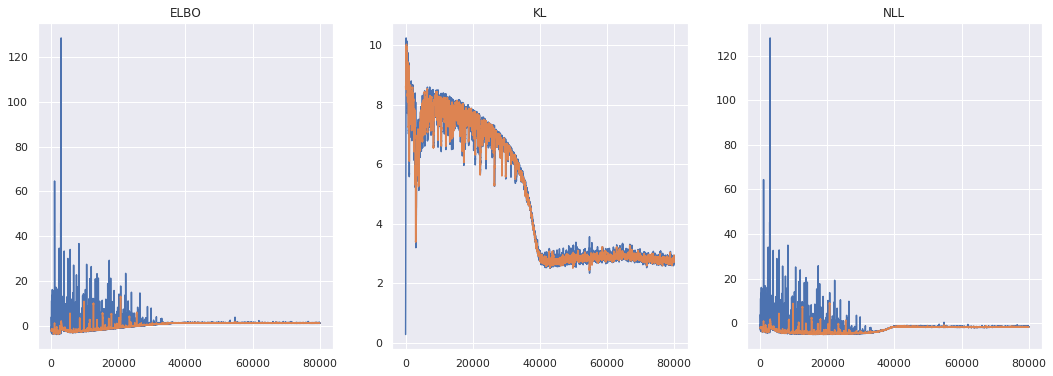

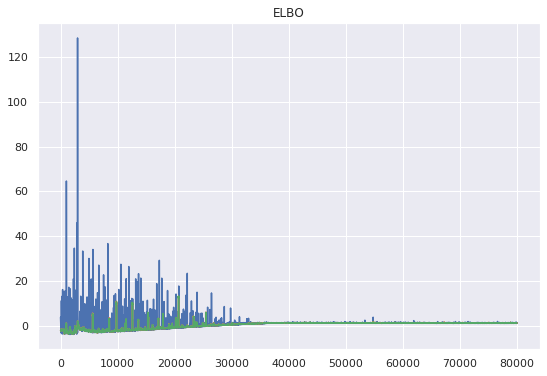

In [0]:
#not using scalar
warmup = DeterministicWarmup(start_epochs=0,max_epochs=500)
net = VariationalAutoencoder(latent_features, 1, False, beta = warmup)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
fit(data_c_train, data_c_val, data_c_test,epochs = 1000)

In [0]:
def plotter(a_new,y):
    f, axarr = plt.subplots(2,2, figsize=(14,8))
    net.num_samples=1
    net.eval()
    z = torch.randn(1000, 2)
    full_generation_path, without_decoder_noise = net.sample(z)
    full_generation_path = full_generation_path.data.numpy() 
    without_decoder_noise = without_decoder_noise.data.numpy()
    x_rec = net.forward(a_new[0:1000])['x_hat'].data.numpy()
    # Split encoder outputs into a mean and variance vector      
    mu, log_var = torch.chunk(net.encoder(a_new[0:1000]), 2, dim=-1)
    z = net.Reparametrisation(mu,log_var,1)

    x_rec = x_rec.squeeze(1)
    full_generation_path = full_generation_path.squeeze(1)
    without_decoder_noise = without_decoder_noise.squeeze(1)
    z = z.squeeze(1)
    
    ax = axarr[0][0]
    ax.set_title('Reconstruced samples')
    ax.scatter(a_new[:1000,0].data.numpy(),a_new[:1000,1].data.numpy())
    ax.scatter(x_rec[:,0],x_rec[:,1], c=y[:1000])
    ax.axis('equal')

    ax = axarr[0][1]
    ax.set_title('latent space')
    ax.scatter(z[:,0].data.numpy(),z[:,1].data.numpy(),c=y[:1000])
    ax.axis('equal')

    ax = axarr[1][0]
    ax.scatter(a_new[:1000,0].data.numpy(),a_new[:1000,1].data.numpy())
    ax.scatter(full_generation_path[:,0],full_generation_path[:,1])
    ax.set_title('samples using full generation path from latent space')
    ax.axis('equal')

    ax = axarr[1][1]
    ax.scatter(a_new[:1000,0].data.numpy(),a_new[:1000,1].data.numpy())
    ax.scatter(without_decoder_noise[:,0],without_decoder_noise[:,1])
    ax.set_title('samples without decoder noise from latent space')
    ax.axis('equal')
    plt.show()


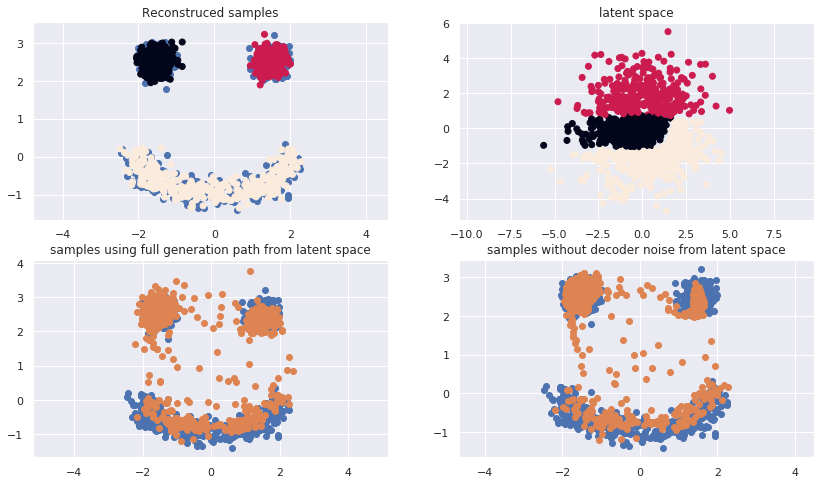

In [0]:
plotter(c_new,y)

Epoch 0: loss 2.6470508575439453 kl 0.09035886824131012 nll 2.556691884994507 
Epoch 10: loss 1.3410693407058716 kl 1.4716591835021973 nll -0.1305897980928421 
Epoch 20: loss 1.2679133415222168 kl 1.5431417226791382 nll -0.2752283215522766 
Epoch 30: loss 1.2602007389068604 kl 1.543508529663086 nll -0.28330785036087036 
Epoch 40: loss 1.2686383724212646 kl 1.5575333833694458 nll -0.2888950705528259 
Epoch 50: loss 1.1891381740570068 kl 1.543168306350708 nll -0.3540300726890564 
Epoch 60: loss 1.1802244186401367 kl 1.6301043033599854 nll -0.44987988471984863 
Epoch 70: loss 1.1270205974578857 kl 1.76898193359375 nll -0.6419613361358643 
Epoch 80: loss 1.1288981437683105 kl 1.822235345840454 nll -0.6933372020721436 
Epoch 90: loss 1.0607688426971436 kl 1.817450761795044 nll -0.7566818594932556 
test loss 1.0803823471069336  test kl 1.8007934093475342 test nll -0.7204110622406006 


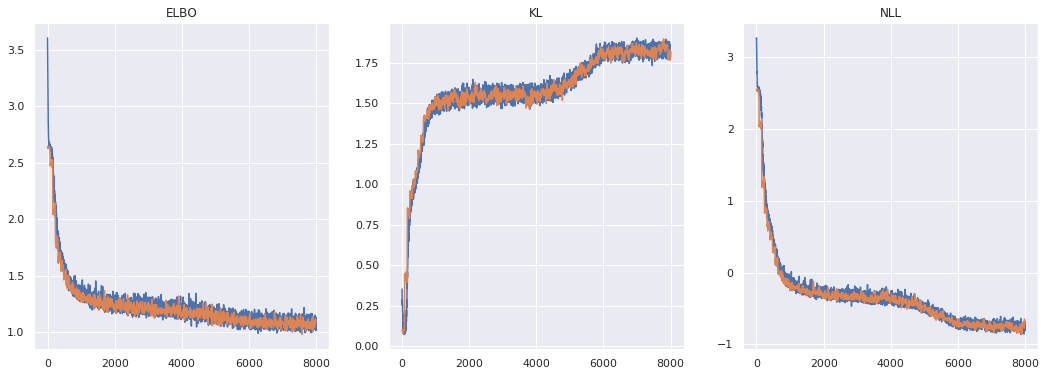

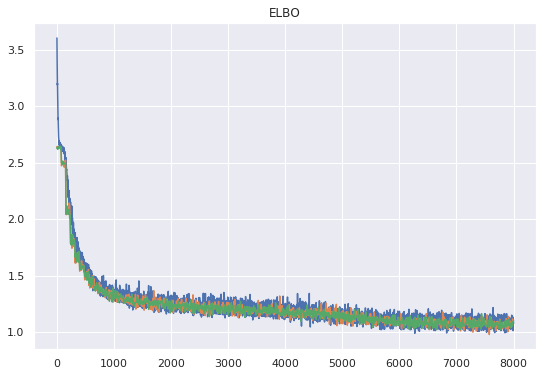

In [0]:
#not using scalar
warmup = DeterministicWarmup(start_epochs=0,max_epochs=1)
net = VariationalAutoencoder(latent_features, 1, False, beta = warmup)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
fit(data_c_train, data_c_val, data_c_test,epochs = 100)

In [0]:
def plotter(a_new,y):
    f, axarr = plt.subplots(2,2, figsize=(14,8))
    net.num_samples=1
    net.eval()
    z = torch.randn(1000, 2)
    full_generation_path, without_decoder_noise = net.sample(z)
    full_generation_path = full_generation_path.data.numpy() 
    without_decoder_noise = without_decoder_noise.data.numpy()
    x_rec = net.forward(a_new[0:1000])['x_hat'].data.numpy()
    # Split encoder outputs into a mean and variance vector      
    mu, log_var = torch.chunk(net.encoder(a_new[0:1000]), 2, dim=-1)
    z = net.Reparametrisation(mu,log_var,1)

    x_rec = x_rec.squeeze(1)
    full_generation_path = full_generation_path.squeeze(1)
    without_decoder_noise = without_decoder_noise.squeeze(1)
    z = z.squeeze(1)
    
    ax = axarr[0][0]
    ax.set_title('Reconstruced samples')
    ax.scatter(a_new[:1000,0].data.numpy(),a_new[:1000,1].data.numpy())
    ax.scatter(x_rec[:,0],x_rec[:,1], c=y[:1000])
    ax.axis('equal')

    ax = axarr[0][1]
    ax.set_title('latent space')
    ax.scatter(z[:,0].data.numpy(),z[:,1].data.numpy(),c=y[:1000])
    ax.axis('equal')

    ax = axarr[1][0]
    ax.scatter(a_new[:1000,0].data.numpy(),a_new[:1000,1].data.numpy())
    ax.scatter(full_generation_path[:,0],full_generation_path[:,1])
    ax.set_title('samples using full generation path from latent space')
    ax.axis('equal')

    ax = axarr[1][1]
    ax.scatter(a_new[:1000,0].data.numpy(),a_new[:1000,1].data.numpy())
    ax.scatter(without_decoder_noise[:,0],without_decoder_noise[:,1])
    ax.set_title('samples without decoder noise from latent space')
    ax.axis('equal')
    plt.show()


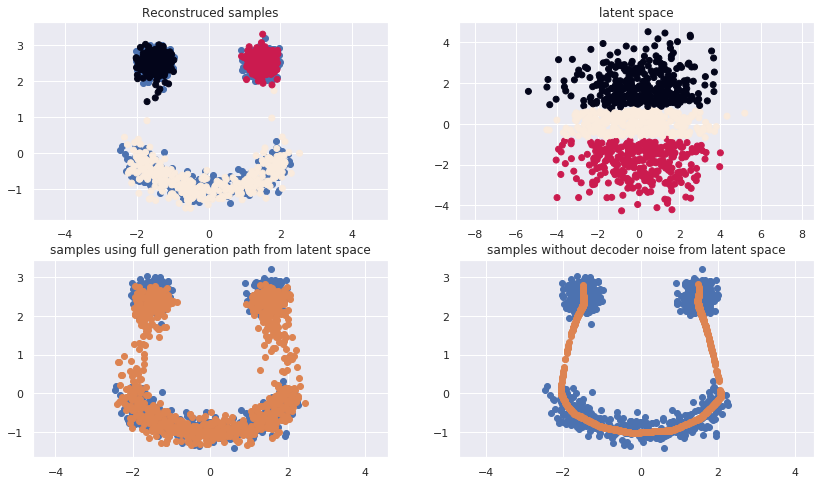

In [0]:
plotter(c_new,y)

Epoch 0: loss 1.7803173065185547 kl 1.2674685716629028 nll 1.7380683422088623 
Epoch 10: loss -0.37190234661102295 kl 4.277133941650391 nll -1.9401848316192627 
Epoch 20: loss 0.7945212125778198 kl 3.3094398975372314 nll -1.5220867395401 
Epoch 30: loss 1.5237255096435547 kl 2.0473337173461914 nll -0.5236081480979919 
Epoch 40: loss 1.45192289352417 kl 1.7384649515151978 nll -0.2865421175956726 
Epoch 50: loss 1.3660646677017212 kl 1.698855996131897 nll -0.3327912986278534 
Epoch 60: loss 1.327715516090393 kl 1.6683071851730347 nll -0.340591698884964 
Epoch 70: loss 1.3267185688018799 kl 1.7451939582824707 nll -0.41847535967826843 
Epoch 80: loss 1.3158200979232788 kl 1.6920156478881836 nll -0.3761955797672272 
Epoch 90: loss 1.3924915790557861 kl 1.7632652521133423 nll -0.37077370285987854 
Epoch 100: loss 1.3288553953170776 kl 1.7754980325698853 nll -0.44664260745048523 
Epoch 110: loss 1.375873327255249 kl 1.7607526779174805 nll -0.38487938046455383 
Epoch 120: loss 1.27094292640686

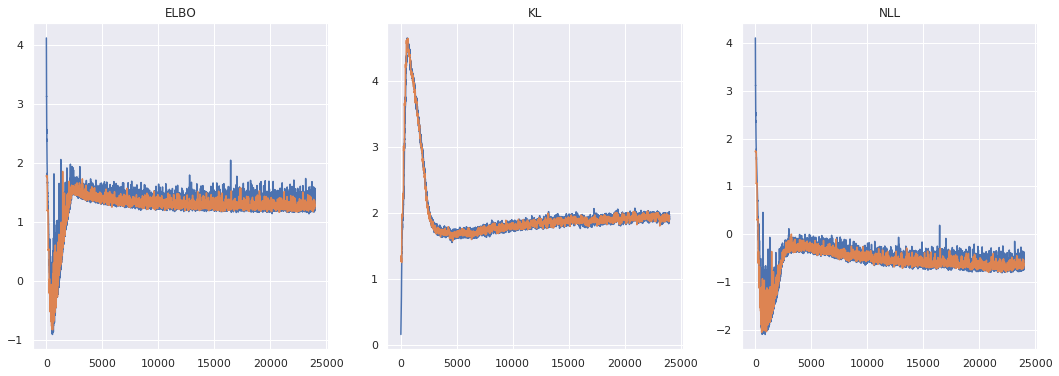

In [0]:
#not using scalar
warmup = DeterministicWarmup(start_epochs=0,max_epochs=30)
net = VariationalAutoencoder(latent_features, num_samples, scalar, beta = warmup)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
fit(data_c_train, data_c_val, data_c_test,epochs = 300)

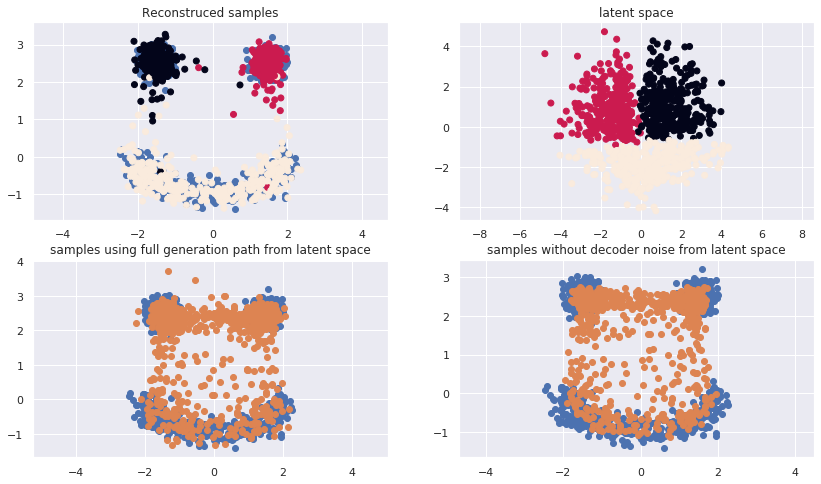

In [0]:
plotter(c_new,y)

# Part 2



In [0]:
import pickle
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
with open('/content/gdrive/My Drive/datasets/hw3-q2.pkl','rb') as f:
    data = pickle.load(f)

In [0]:
train = data['train']

In [0]:
val = data['valid']

In [0]:
test = data['test']

In [0]:
train[0].shape

(32, 32, 3)

In [0]:
train[0].dtype

dtype('uint8')

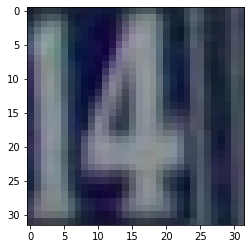

In [0]:
plt.imshow(train[0])

In [0]:
class DataSet:

    def __init__(self,X):
        """Init function should not do any heavy lifting, but
            must initialize how many items are available in this data set.
        """
        
        self.images = X

    def __len__(self):
        """return number of points in our dataset"""

        return len(self.images)

    def __getitem__(self, idx):
        """ Here we have to return the item requested by `idx`
            The PyTorch DataLoader class will use this method to make an iterable for
            our training or validation loop.
        """

        img = self.images[idx]

        return img

In [0]:
import torch
import numpy as np
data_a_train = DataSet(torch.FloatTensor(train[:1000]).permute(0,3,1,2).cuda())
data_a_val = DataSet(torch.FloatTensor(val[:1000]).permute(0,3,1,2).cuda())
data_a_test = DataSet(torch.FloatTensor(test[:1000]).permute(0,3,1,2).cuda())


In [0]:
example = np.array(next(iter(data_a_train)).permute(1,2,0).cpu(),dtype='uint8')
print(example.shape)

(32, 32, 3)


In [0]:
example.dtype

dtype('uint8')

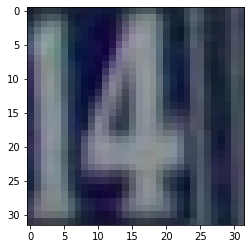

In [0]:
plt.imshow(example)

In [0]:
class DeterministicWarmup(object):
    """
    Linear deterministic warm-up as described in
    [Sønderby 2016].
    """
    def __init__(self, start_epochs=0, max_epochs=100, t_max=1):
        self.t = 0
        self.t_max = t_max
        self.inc = 1/max_epochs
        self.start_epochs=start_epochs

    def __iter__(self):
        return self

    def __next__(self, epoch):
        if epoch>=self.start_epochs:
            t = self.t + self.inc
            self.start_epochs +=1
            self.t = self.t_max if t >= self.t_max else t
        return self.t

In [0]:
import torch
import torch.nn as nn
from torch.nn.functional import softplus
from torch import optim
import torch.nn.functional as F
import numpy as np

warmup = DeterministicWarmup(max_epochs=25)


In [0]:
class gated_shortcut_connection(nn.Module):
    def __init__(self,channels=16):

        super(gated_shortcut_connection,self).__init__()

        self.channels= channels

        self.A = nn.Conv2d(self.channels, self.channels*2, 1, stride=1, padding=0)
        self.B = nn.Conv2d(self.channels, self.channels*2, 1, stride=1, padding=0)
        self.channels=channels

    def forward(self,x):
        A = self.A(x)
        B = self.B(x)
        shortcut = torch.mul(A,torch.sigmoid(B+1e-5))
        return shortcut
        

In [0]:
class ResidualBlock(nn.Module):
  def __init__(self, channels=32):
    super(ResidualBlock, self).__init__()

    self.channels = channels

    self.layers = nn.Sequential(
      nn.ReLU(),
      nn.Conv2d(self.channels , self.channels//4, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(self.channels //4, self.channels//2, kernel_size=3, padding=1),
      gated_shortcut_connection()
    )

  def forward(self, x):
    return self.layers(x) + x


class Residual_stack(nn.Module):
  def __init__(self, num_blocks=5, channels=32):
    super(ResidualStack, self).__init__()

    self.channels=

    self.layers = nn.Sequential(*[ResidualBlock() for _ in range(num_blocks)])

  def forward(self, x):
    return F.relu(self.layers(x))

In [0]:
class Residual_stack(nn.Module):
    def __init__(self, channels=32):

        super(Residual_stack, self).__init__()

        self.channels = channels

        self.layers = []
        
        for _ in range(5):
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Conv2d(self.channels,4, 3, stride=1, padding=1))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Conv2d(4,int(self.channels/2), 3, stride=1, padding=1))
            self.layers.append(gated_shortcut_connection(channels = int(self.channels/2)))

        self.layers.append(nn.ReLU())
        self.total_layer = nn.Sequential(*self.layers)

    def forward(self,x):
        out = self.total_layer(x) + x
        return out

In [0]:
class Stochastic(nn.Module):
    """
    Base stochastic layer that uses the
    reparametrization trick [Kingma 2013]
    to draw a sample from a distribution
    parametrised by mu and log_var.
    """

    def reparametrize(self,mu, log_var, num_samples):
        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)

        # Don't propagate gradients through randomness
        
        with torch.no_grad():

            epsilon = torch.randn(num_samples,*mu.shape).cuda()

        sigma = torch.exp(0.5*log_var)
        
        # We will need to unsqueeze to turn
        # (batch_size, latent_dim) -> (batch_size, 1, latent_dim)
        z = mu + epsilon * sigma

        return z

class GaussianSample(Stochastic):
    """
    Layer that represents a sample from a
    Gaussian distribution.
    """
    def __init__(self, num_samples):
        super(GaussianSample, self).__init__()
        self.num_samples = num_samples

    def forward(self, mu, log_var):

        return self.reparametrize(mu, log_var, self.num_samples), mu, log_var

In [0]:
import torch.nn as nn
import torch

class TotalNetwork(nn.Module):
    def __init__(self,channels=16, num_samples=1, beta=warmup):

        super(TotalNetwork,self).__init__()
        self.channels = channels
        self.num_samples = num_samples
        self.beta = beta

         # We encode the data onto the latent space using two linear layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3,self.channels, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.channels,self.channels*2, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.channels*2,self.channels*2, 3, stride=1, padding=1),
            Residual_stack(channels = self.channels*2),
            nn.Conv2d(self.channels*2,self.channels*4, 3, stride=1, padding=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.channels*2,self.channels*2, 3, stride=1, padding=1),
            Residual_stack(channels= self.channels*2),
            nn.ReLU(),
            nn.ConvTranspose2d(self.channels*2,self.channels, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.channels, 3*2, 4, stride=2, padding=1),
        )

        self.Reparametrisation = GaussianSample(self.num_samples)
        self.reconstruct_sample = GaussianSample(1)


    def forward(self, x): 
        outputs = {}
        
        # Split encoder outputs into a mean and variance vector     
        x = self.encoder(x)

        mu, log_var = torch.chunk(x, 2, dim=1)


        # :- Reparametrisation trick
        z, q_mu, q_log_var = self.Reparametrisation(mu,log_var)  
        _,rgb,ch,w,h=z.shape
        z = z.reshape(-1,ch,w,h)

        # Run through decoder and sample reconstruction
        x_sample = self.decoder(z)

        # split in 2 parts
        x_mu, x_log_var = torch.chunk(x_sample, 2, dim=1)

        x_hat, x_mu, x_log_var = self.reconstruct_sample(x_mu,x_log_var)  
        x_hat = x_hat.squeeze(0)

        outputs["x_hat"] = x_hat
        outputs["z"] = z
        outputs["mu"] =q_mu
        outputs["log_var"] = q_log_var
        outputs["x_mu"] = x_mu
        outputs["x_log_var"] = x_log_var

        return outputs
    
    def sample(self, z):
        """
        Given z ~ N(0, I) generates a sample from
        the learned distribution based on p_θ(x|z).
        :param z: (torch.autograd.Variable) Random normal variable
        :return: (torch.autograd.Variable) generated sample
        """
        if len(z.shape)<3:
            z = z.unsqueeze(1)
        x_sample = self.decoder(z)
        x_mu, x_log_var = torch.chunk(x_sample, 2, dim=-1)
        full_generation_path = self.Reparametrisation(x_mu,x_log_var,1)  
        without_decoder_noise = x_mu
        return full_generation_path, without_decoder_noise

    def loss_function(self, t, q_mu, q_log_var, x_mu, x_log_var, z, epoch):
        # Reconstruction error, log[p(x|z)]
        # Sum over features

        #likelihood = F.mse_loss(y,t,reduction='none')
        #likelihood = likelihood.view(likelihood.size(0),-1).sum(1)
        #log_pxz = log_normal, rec loss

        likelihood = torch.mean(torch.sum(-log_normal(t,x_mu,x_log_var),dim=1),dim=(1,2))
        # regularization error:
        p_mu, p_log_var = torch.zeros_like(q_mu), torch.ones_like(q_log_var)

        log_qz = log_normal(z, q_mu, q_log_var)
        log_pz = log_normal(z, p_mu, p_log_var)
        kl = torch.mean(torch.sum(log_qz - log_pz,dim=1),dim=(1,2))

        # Regularization error: 
        # Kulback-Leibler divergence between approximate posterior, q(z|x)
        # and prior p(z) = N(z | mu, sigma*I).
        
        # In the case of the KL-divergence between diagonal covariance Gaussian and 
        # a standard Gaussian, an analytic solution exists. Using this excerts a lower
        # variance estimator of KL(q||p)
        #kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)

        # Combining the two terms in the evidence lower bound objective (ELBO) 
        # mean over batch
        nll = torch.mean(likelihood)/np.log(2)/(32*32*3)
        kl = torch.mean(kl)/np.log(2)/(32*32*3)
        print(nll)
        self.beta.__next__(epoch)
        ELBO = nll + kl #self.beta.t*kl
        
        # notice minus sign as we want to maximise ELBO
        return ELBO, kl, nll

def log_normal(x, mean, log_var, eps=1e-5):
    c = - 0.5 * np.log(2*np.pi)
    return c - log_var/2 - (x - mean)**2 / (2 * torch.exp(log_var) + eps)
        

In [0]:
net = TotalNetwork().cuda()

TypeError: ignored

In [0]:
x = next(iter(data_a_train)).unsqueeze(0)
outputs = net.forward(x)

In [0]:
outputs['x_hat'].shape

torch.Size([1, 3, 32, 32])

In [0]:
mu, log_var = outputs["mu"], outputs["log_var"]
x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
z = outputs["z"]
print(x.shape)
print(x_log_var.shape)
print(x_mu.shape)


torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


In [0]:
loss,kl,nll = net.loss_function(x, mu, log_var,x_mu,x_log_var,z, 1)

print(loss)

tensor(5.9155, device='cuda:0', grad_fn=<AddBackward0>)


In [0]:
def fit(data_a_train, data_a_val, data_a_test, epochs=50):
    import matplotlib.pyplot as plt

    losses, val_losses =[],[]
    batch_size = 1000

    train_iter = torch.utils.data.DataLoader(dataset=data_a_train,batch_size=batch_size)
    val_iter = torch.utils.data.DataLoader(dataset=data_a_val,batch_size=batch_size)
    test_iter = torch.utils.data.DataLoader(dataset=data_a_test,batch_size=batch_size)


    losses = []
    val_losses = []
    val_losses100 = []
    kls = []
    val_kls = []
    val_kls100 = []
    nlls = []
    val_nlls = []
    val_nlls100 = []

    for epoch in range(epochs):
        net.num_samples=1
        net.train()

        loss = 0
        
        for train_X in train_iter:
            
            outputs = net(train_X.cuda())
            
            x_hat = outputs["x_hat"]
            mu, log_var = outputs["mu"], outputs["log_var"]
            x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
            z = outputs["z"]
            
            loss, kl, nll = net.loss_function(train_X, mu, log_var,x_mu, x_log_var,z, epoch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.cpu().data.numpy())
            kls.append(kl.cpu().data.numpy())
            nlls.append(nll.cpu().data.numpy())

            
        with torch.set_grad_enabled(False):
            net.eval()

            for val_X in val_iter:
                
                outputs = net(val_X.cuda())

                x_hat = outputs["x_hat"]
                mu, log_var = outputs["mu"], outputs["log_var"]
                x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
                z = outputs["z"]

                val_loss, val_kl, val_nll = net.loss_function(val_X, mu, log_var, x_mu, x_log_var, z, epoch)

                val_losses.append(val_loss.cpu().data.numpy())
                val_kls.append(val_kl.cpu().data.numpy())
                val_nlls.append(val_nll.cpu().data.numpy())


        if epoch % 10 ==0:
            print('Epoch {}: loss {} kl {} nll {} '.format(epoch,loss.item(),kl.item(),nll.item()))
            #plot an example
            x = val_X[0:1]
            output = net.forward(x)
            print(x.shape)
            example = np.array(x.squeeze(0).permute(1,2,0).cpu(),dtype='uint8')
            plt.imshow(example)
            plt.show()
            out = output['x_hat'].squeeze(0).permute(1,2,0).cpu().detach()
            v = np.array(out,dtype='uint8')
            plt.imshow(v)
            plt.show()



    test_losses = []
    test_kls = []
    test_nlls = []
    for test_X in test_iter:
    
        outputs = net(test_X)

        x_hat = outputs["x_hat"]
        mu, log_var = outputs["mu"], outputs["log_var"]
        x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
        z = outputs["z"]

        test_loss, test_kl, test_nll = net.loss_function(test_X, mu, log_var, x_mu, x_log_var, z, epoch)

        test_losses.append(test_loss.cpu().data.numpy())
        test_kls.append(test_kl.cpu().data.numpy())
        test_nlls.append(test_nll.cpu().data.numpy())


    print('test loss {}  test kl {} test nll {} '.format(np.mean(test_losses),np.mean(test_kls),np.mean(test_nlls)))
    import matplotlib.pyplot as plt
    f, axarr = plt.subplots(1,3, figsize=(18,6))

    ax = axarr[0]
    ax.set_title('ELBO')
    ax.plot(losses, label = "ELBO_train_loss")
    ax.plot(np.arange(0, len(losses),(len(losses)/len(val_losses))),val_losses, label = "ELBO_val_loss")

    ax = axarr[1]
    ax.set_title('KL')
    ax.plot(kls, label = "kl_train_loss")
    ax.plot(np.arange(0, len(kls),(len(kls)/len(val_kls))),val_kls, label = "KL_val_loss")

    ax = axarr[2]
    ax.set_title('NLL')
    ax.plot(nlls, label = "NLL_train_loss")
    ax.plot(np.arange(0, len(nlls),(len(nlls)/len(val_nlls))),val_nlls, label = "NLL_val_loss")
    plt.show()

    import matplotlib.pyplot as plt
    f, ax = plt.subplots(1,1, figsize=(9,6))

    ax.set_title('ELBO')
    ax.plot(losses, label = "ELBO_train_loss")
    ax.plot(np.arange(0, len(losses),(len(losses)/len(val_losses))),val_losses, label = "IWAE 1")
    plt.show()


tensor(19.9474, device='cuda:0', grad_fn=<DivBackward0>)
tensor(11.5970, device='cuda:0')
Epoch 0: loss 20.20128631591797 kl 0.2538989782333374 nll 19.9473876953125 
torch.Size([1, 3, 32, 32])


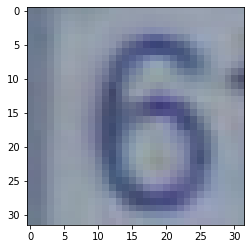

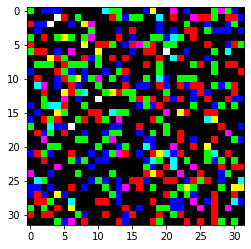

tensor(11.3247, device='cuda:0', grad_fn=<DivBackward0>)
tensor(10.8699, device='cuda:0')
tensor(10.8669, device='cuda:0', grad_fn=<DivBackward0>)
tensor(10.6616, device='cuda:0')
tensor(10.6537, device='cuda:0', grad_fn=<DivBackward0>)
tensor(10.5349, device='cuda:0')
tensor(10.5341, device='cuda:0', grad_fn=<DivBackward0>)
tensor(10.4444, device='cuda:0')
tensor(10.4472, device='cuda:0', grad_fn=<DivBackward0>)
tensor(10.3728, device='cuda:0')
tensor(10.3819, device='cuda:0', grad_fn=<DivBackward0>)
tensor(10.3201, device='cuda:0')
tensor(10.3220, device='cuda:0', grad_fn=<DivBackward0>)
tensor(10.2593, device='cuda:0')
tensor(10.2668, device='cuda:0', grad_fn=<DivBackward0>)
tensor(10.2073, device='cuda:0')
tensor(10.2151, device='cuda:0', grad_fn=<DivBackward0>)
tensor(10.1552, device='cuda:0')
tensor(10.1628, device='cuda:0', grad_fn=<DivBackward0>)
tensor(10.1032, device='cuda:0')
Epoch 10: loss 10.205954551696777 kl 0.043197151273489 nll 10.162757873535156 
torch.Size([1, 3, 32,

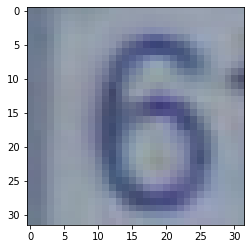

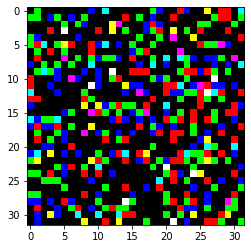

tensor(10.1109, device='cuda:0', grad_fn=<DivBackward0>)
tensor(10.0496, device='cuda:0')
tensor(10.0564, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.9925, device='cuda:0')
tensor(10.0003, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.9340, device='cuda:0')
tensor(9.9403, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.8713, device='cuda:0')
tensor(9.8782, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.8022, device='cuda:0')
tensor(9.8105, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.7317, device='cuda:0')
tensor(9.7372, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.6540, device='cuda:0')
tensor(9.6598, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.5704, device='cuda:0')
tensor(9.5777, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.4807, device='cuda:0')
tensor(9.4871, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.3849, device='cuda:0')
Epoch 20: loss 9.534323692321777 kl 0.047209419310092926 nll 9.487113952636719 
torch.Size([1, 3, 32, 32])


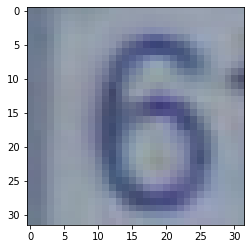

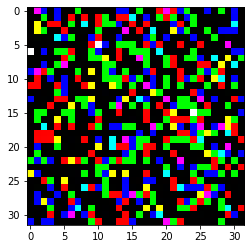

tensor(9.3913, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.2820, device='cuda:0')
tensor(9.2879, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.1723, device='cuda:0')
tensor(9.1773, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.0542, device='cuda:0')
tensor(9.0585, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.9273, device='cuda:0')
tensor(8.9314, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.7919, device='cuda:0')
tensor(8.7953, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.6477, device='cuda:0')
tensor(8.6491, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4919, device='cuda:0')
tensor(8.4943, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.3260, device='cuda:0')
tensor(8.3274, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.1504, device='cuda:0')
tensor(8.1483, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.9598, device='cuda:0')
Epoch 30: loss 8.215141296386719 kl 0.0668213814496994 nll 8.148320198059082 
torch.Size([1, 3, 32, 32])


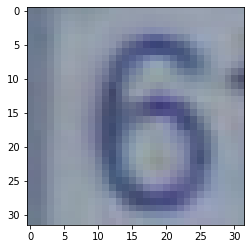

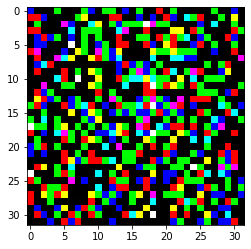

tensor(7.9579, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.7562, device='cuda:0')
tensor(7.7545, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.5418, device='cuda:0')
tensor(7.5391, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.3144, device='cuda:0')
tensor(7.3099, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.0728, device='cuda:0')
tensor(7.0676, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.8203, device='cuda:0')
tensor(6.8137, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.5600, device='cuda:0')
tensor(6.5525, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.2890, device='cuda:0')
tensor(6.2799, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.0127, device='cuda:0')
tensor(6.0027, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.7313, device='cuda:0')
tensor(5.7200, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.4484, device='cuda:0')
Epoch 40: loss 5.828458309173584 kl 0.10846957564353943 nll 5.719988822937012 
torch.Size([1, 3, 32, 32])


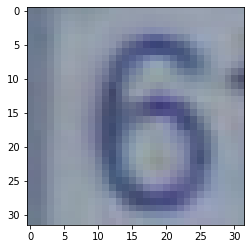

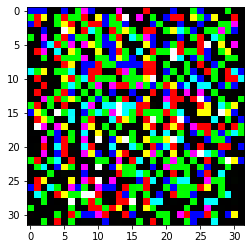

tensor(5.4344, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.1635, device='cuda:0')
tensor(5.1500, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.8807, device='cuda:0')
tensor(4.8659, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.6001, device='cuda:0')
tensor(4.5852, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.3233, device='cuda:0')
tensor(4.3077, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.0529, device='cuda:0')
tensor(4.0358, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.7873, device='cuda:0')
tensor(3.7701, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.5291, device='cuda:0')
tensor(3.5111, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.2776, device='cuda:0')
tensor(3.2606, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.0374, device='cuda:0')
tensor(3.0188, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.8086, device='cuda:0')
Epoch 50: loss 3.2002604007720947 kl 0.1814853996038437 nll 3.01877498626709 
torch.Size([1, 3, 32, 32])


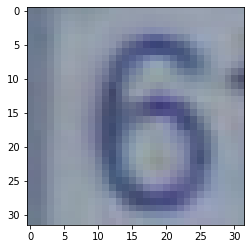

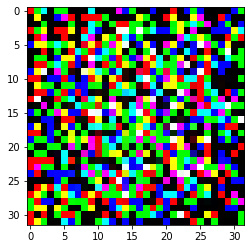

tensor(2.7902, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.5919, device='cuda:0')
tensor(2.5733, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.3889, device='cuda:0')
tensor(2.3708, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.2009, device='cuda:0')
tensor(2.1827, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.0279, device='cuda:0')
tensor(2.0099, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.8690, device='cuda:0')
tensor(1.8512, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.7244, device='cuda:0')
tensor(1.7073, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.5943, device='cuda:0')
tensor(1.5769, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4769, device='cuda:0')
tensor(1.4596, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3711, device='cuda:0')
tensor(1.3545, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2771, device='cuda:0')
Epoch 60: loss 1.628539800643921 kl 0.27402573823928833 nll 1.3545141220092773 
torch.Size([1, 3, 32, 32])


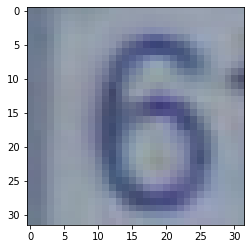

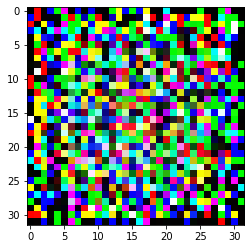

tensor(1.2608, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1918, device='cuda:0')
tensor(1.1763, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1163, device='cuda:0')
tensor(1.1007, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0474, device='cuda:0')
tensor(1.0330, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9857, device='cuda:0')
tensor(0.9717, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9298, device='cuda:0')
tensor(0.9160, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8798, device='cuda:0')
tensor(0.8665, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8338, device='cuda:0')
tensor(0.8209, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7926, device='cuda:0')
tensor(0.7799, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7549, device='cuda:0')
tensor(0.7429, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7209, device='cuda:0')
Epoch 70: loss 1.0897610187530518 kl 0.3469049632549286 nll 0.7428560256958008 
torch.Size([1, 3, 32, 32])


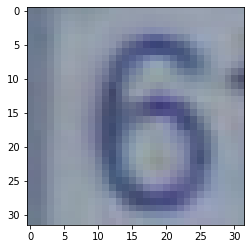

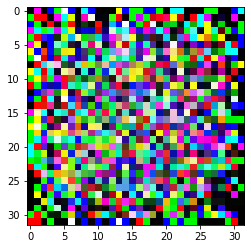

tensor(0.7088, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6892, device='cuda:0')
tensor(0.6775, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6599, device='cuda:0')
tensor(0.6487, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6331, device='cuda:0')
tensor(0.6222, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6081, device='cuda:0')
tensor(0.5977, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5848, device='cuda:0')
tensor(0.5750, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5636, device='cuda:0')
tensor(0.5538, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5437, device='cuda:0')
tensor(0.5341, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5253, device='cuda:0')
tensor(0.5158, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5081, device='cuda:0')
tensor(0.4990, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4923, device='cuda:0')
Epoch 80: loss 0.881331741809845 kl 0.38229674100875854 nll 0.4990350008010864 
torch.Size([1, 3, 32, 32])


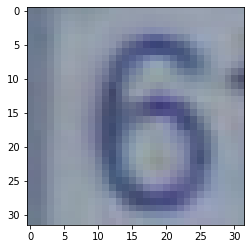

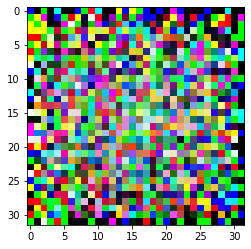

tensor(0.4834, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4775, device='cuda:0')
tensor(0.4691, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4638, device='cuda:0')
tensor(0.4555, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4517, device='cuda:0')
tensor(0.4434, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4402, device='cuda:0')
tensor(0.4318, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4293, device='cuda:0')
tensor(0.4213, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4194, device='cuda:0')
tensor(0.4115, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4103, device='cuda:0')
tensor(0.4022, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4014, device='cuda:0')
tensor(0.3935, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3932, device='cuda:0')
tensor(0.3854, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3856, device='cuda:0')
Epoch 90: loss 0.7635419368743896 kl 0.37812066078186035 nll 0.3854212760925293 
torch.Size([1, 3, 32, 32])


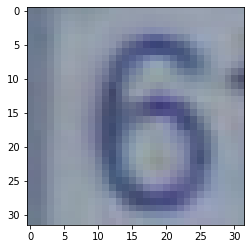

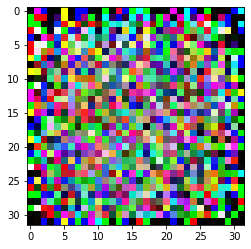

tensor(0.3777, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3785, device='cuda:0')
tensor(0.3706, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3714, device='cuda:0')
tensor(0.3638, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3649, device='cuda:0')
tensor(0.3575, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3588, device='cuda:0')
tensor(0.3512, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3527, device='cuda:0')
tensor(0.3453, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3472, device='cuda:0')
tensor(0.3400, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3417, device='cuda:0')
tensor(0.3345, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3366, device='cuda:0')
tensor(0.3295, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3316, device='cuda:0')
tensor(0.3245, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3268, device='cuda:0')
Epoch 100: loss 0.679459810256958 kl 0.3549761474132538 nll 0.32448363304138184 
torch.Size([1, 3, 32, 32])


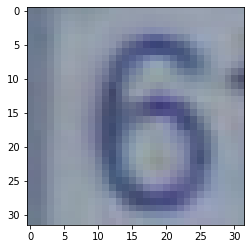

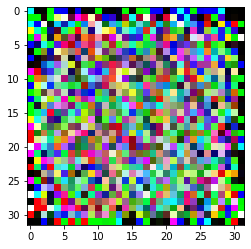

tensor(0.3195, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3219, device='cuda:0')
tensor(0.3150, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3171, device='cuda:0')
tensor(0.3105, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3126, device='cuda:0')
tensor(0.3058, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3080, device='cuda:0')
tensor(0.3010, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3030, device='cuda:0')
tensor(0.2964, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2982, device='cuda:0')
tensor(0.2916, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2929, device='cuda:0')
tensor(0.2864, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2872, device='cuda:0')
tensor(0.2808, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2810, device='cuda:0')
tensor(0.2748, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2743, device='cuda:0')
Epoch 110: loss 0.603651762008667 kl 0.3288412094116211 nll 0.2748105525970459 
torch.Size([1, 3, 32, 32])


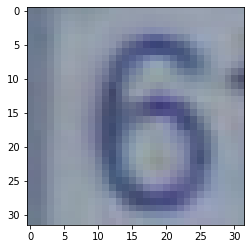

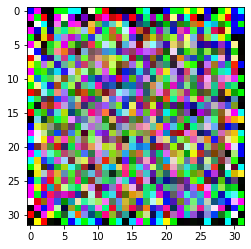

tensor(0.2683, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2669, device='cuda:0')
tensor(0.2610, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2584, device='cuda:0')
tensor(0.2525, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2492, device='cuda:0')
tensor(0.2435, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2395, device='cuda:0')
tensor(0.2341, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2291, device='cuda:0')
tensor(0.2241, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2188, device='cuda:0')
tensor(0.2139, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2089, device='cuda:0')
tensor(0.2041, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2004, device='cuda:0')
tensor(0.1957, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1956, device='cuda:0')
tensor(0.1912, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1923, device='cuda:0')
Epoch 120: loss 0.49132585525512695 kl 0.3001251816749573 nll 0.19120065867900848 
torch.Size([1, 3, 32, 32])


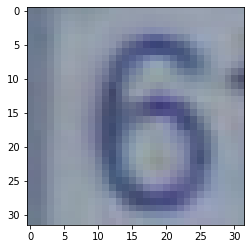

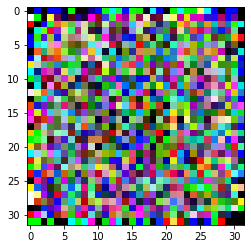

tensor(0.1880, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
Epoch 130: loss nan kl nan nll nan 
torch.Size([1, 3, 32, 32])


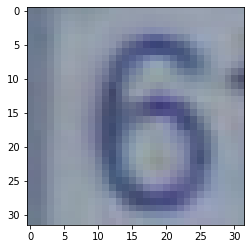

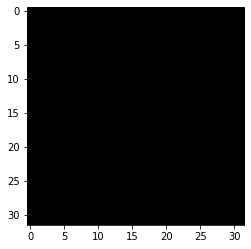

tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
Epoch 140: loss nan kl nan nll nan 
torch.Size([1, 3, 32, 32])


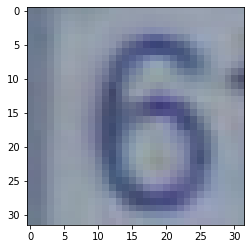

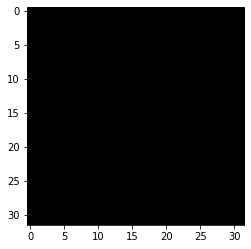

tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)


KeyboardInterrupt: ignored

In [0]:
warmup = DeterministicWarmup(start_epochs=0,max_epochs=100)
net = TotalNetwork( beta = warmup).cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=2e-4)
fit(data_a_train, data_a_val, data_a_test,epochs = 200)

In [0]:
x = next(iter(data_a_test))
inp = x.unsqueeze(0)
outputs = net.forward(inp)
example = np.array(x.permute(1,2,0).cpu(),dtype='uint8')
print(example.shape)

(32, 32, 3)


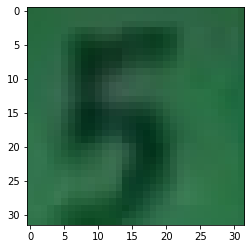

In [0]:
plt.imshow(example)

In [0]:
out = outputs['x_hat'].squeeze(0).permute(1,2,0).cpu().detach()


In [0]:
v = np.array(out,dtype='uint8')

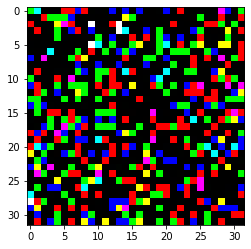

In [0]:
plt.imshow(v)

In [0]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.Image as Image

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


Train: (65931, 32, 32, 3)
Val:   (7326, 32, 32, 3)
Test:  (26032, 32, 32, 3)
Transformed data size: torch.Size([64, 3, 16, 16])


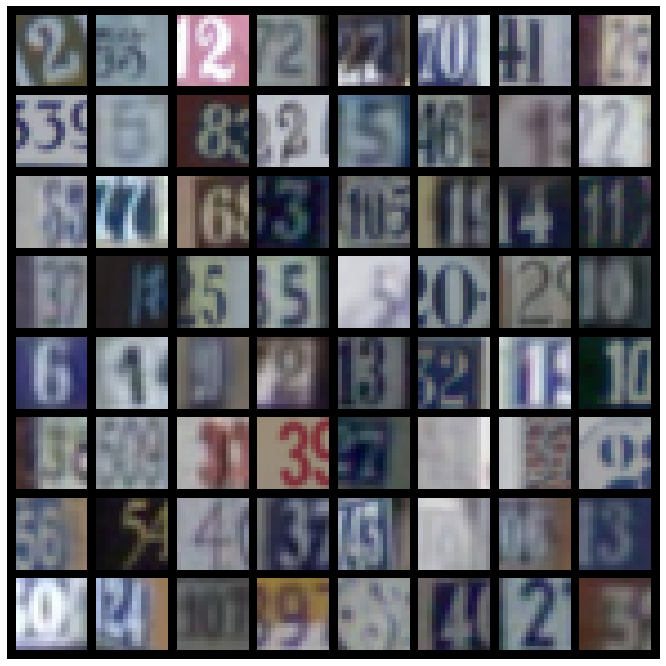

In [0]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
%matplotlib inline
sns.set(style='darkgrid')
with open('/content/gdrive/My Drive/datasets/hw3-q2.pkl','rb') as f:
    data = pickle.load(f)
#data = pkl.load(open('drive/My Drive/Colab Notebooks/hw3-q2.pkl', 'rb'))
data_train, data_val, data_test = data['train']/255, data['valid']/255, data['test']/255
print(f'Train: {data_train.shape}\nVal:   {data_val.shape}\nTest:  {data_test.shape}')

def show(img, renorm=False, nrow=8):
  img_grid = torchvision.utils.make_grid(img, nrow=nrow).numpy()
  plt.figure(figsize=(12,12))
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('off')
  plt.show()

transform = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize(size=(16, 16)),
  transforms.ToTensor()
])

class ImgDataset(Dataset):
  def __init__(self, X):
    self.X = torch.Tensor(X).permute(0, 3, 1, 2)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return transform(self.X[idx]).cuda()

batch_size = 64
dl_train = DataLoader(ImgDataset(data_train), batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ImgDataset(data_val), batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ImgDataset(data_test), batch_size=batch_size, shuffle=True)

output = next(iter(dl_train))
print(f'Transformed data size: {output.size()}')
show(output.cpu())

In [0]:
def evaluate_img(net, dl_test, losses, schedule):
  net.eval()
  loss, nll, kl = losses

  data_batch = next(iter(dl_test))

  recon, recon_z, _, _, _, _ = net(data_batch)
  recon = recon.detach().cpu()
  recon_z = recon_z.detach().cpu()

  z = torch.randn_like(recon_z).cuda()
  samples, _, _ = net.decoder(z)
  samples = samples.detach().cpu()

  samples2, _, _ = net.decoder(z, do_reparam=False)
  samples2 = samples2.detach().cpu()

  betas = [schedule[i] for i in range(len(loss))]

  plt.figure(figsize=(16, 8))

  plt.subplot(2, 4, 1)
  plt.plot(range(len(nll)), (nll/np.log(2))/2)
  plt.title('NLL (bits/dim)')

  plt.subplot(2, 4, 2)
  plt.plot(range(len(kl)), kl)
  plt.title('KL-divergence')

  plt.subplot(2, 4, 3)
  plt.plot(range(len(loss)), loss)
  plt.title('ELBO')

  plt.subplot(2, 4, 4)
  plt.plot(range(len(betas)), betas)
  plt.title('Weight on KL-term (beta)')

  plt.subplot(2, 4, 5)
  plt.title('Original samples')
  img_grid = torchvision.utils.make_grid(data_batch, nrow=8).cpu().numpy()
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('off')

  plt.subplot(2, 4, 6)
  plt.title('Reconstruction')
  img_grid = torchvision.utils.make_grid(torch.clamp(recon, min=0, max=1), nrow=8).cpu().numpy()
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('off')

  plt.subplot(2, 4, 7)
  plt.title('Latent space')
  img_grid = torchvision.utils.make_grid(torch.clamp(recon_z, min=0, max=1), nrow=8).cpu().numpy()
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('off')

  plt.subplot(2, 4, 8)
  plt.title('Samples (with decoder noise)')
  img_grid = torchvision.utils.make_grid(torch.clamp(samples, min=0, max=1), nrow=8).cpu().numpy()
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('off')

  plt.show()
  print('\n\n')

In [0]:
class BetaWarmup():
  def __init__(self, num_epochs=200):
    if num_epochs is None or num_epochs < 1:
      self.schedule = [1]
    else:
      self.schedule = np.linspace(0, 1, num_epochs)

  def __getitem__(self, item):
    try:
      #return 0.01
      return self.schedule[item]
    except:
      return 1


class GatedShortcutConnection(nn.Module):
  def __init__(self):
    super(GatedShortcutConnection, self).__init__()

    self.layers = nn.Sequential(
        nn.ReLU(),
        nn.Conv2d(num_filters//2, num_filters, kernel_size=3, padding=1)
    )

  def forward(self, x):
    return self.layers(x)


class ResidualBlock(nn.Module):
  def __init__(self):
    super(ResidualBlock, self).__init__()

    self.layers = nn.Sequential(
      nn.ReLU(),
      nn.Conv2d(num_filters, num_filters//4, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(num_filters//4, num_filters//2, kernel_size=3, padding=1),
      GatedShortcutConnection()
    )

  def forward(self, x):
    return self.layers(x) + x


class ResidualStack(nn.Module):
  def __init__(self, num_blocks=5):
    super(ResidualStack, self).__init__()

    self.layers = nn.Sequential(*[ResidualBlock() for _ in range(num_blocks)])

  def forward(self, x):
    return F.relu(self.layers(x))


class ImgCoder(nn.Module):
  def __init__(self, encoder=None, decoder=None):
    super(ImgCoder, self).__init__()
    assert encoder is not None or decoder is not None

    self.num_colors = 3

    if encoder:
      self.layers = nn.Sequential(
        nn.Conv2d(self.num_colors, num_filters//2, kernel_size=4, stride=2, padding=9),
        nn.ReLU(),
        nn.Conv2d(num_filters//2, num_filters, kernel_size=4, stride=2, padding=9),
        nn.ReLU(),
        nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1),
        ResidualStack()
      )
      self.mu = nn.Linear(num_filters*num_pixels*num_pixels, self.num_colors*num_pixels*num_pixels)
      self.log_var = nn.Linear(num_filters*num_pixels*num_pixels, self.num_colors*num_pixels*num_pixels)

    elif decoder:
      self.layers = nn.Sequential(
        nn.Conv2d(self.num_colors, num_filters, kernel_size=3, stride=1, padding=1),
        ResidualStack(),
        nn.ConvTranspose2d(num_filters, num_filters//2, kernel_size=4, stride=2, padding=9),
        nn.ReLU(),
        nn.ConvTranspose2d(num_filters//2, self.num_colors, kernel_size=4, stride=2, padding=9)
      )
      self.mu = nn.Linear(self.num_colors*num_pixels*num_pixels, self.num_colors*num_pixels*num_pixels)
      self.log_var = nn.Linear(self.num_colors*num_pixels*num_pixels, self.num_colors*num_pixels*num_pixels)

  def reparam(self, mu, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)

    return mu + eps * std

  def forward(self, x, do_reparam=True):
    x = self.layers(x)
    x = x.view(x.size(0), -1)

    mu = self.mu(x).view(x.size(0), self.num_colors, num_pixels, num_pixels)
    log_var = self.log_var(x).view(x.size(0), self.num_colors, num_pixels, num_pixels)

    if do_reparam:
      x = self.reparam(mu, log_var)
    else:
      x = mu

    return x, mu, log_var


class ImgVAE(nn.Module):
  def __init__(self):
    super(ImgVAE, self).__init__()

    self.encoder = ImgCoder(encoder=True)
    self.decoder = ImgCoder(decoder=True)

  def forward(self, x):
    if not isinstance(x, torch.Tensor):
      x = torch.Tensor(x).cuda()

    if not x.shape[1] == 3:
      x = x.permute(0, 3, 1, 2)

    z, z_mu, z_log_var = self.encoder(x)
    x, x_mu, x_log_var = self.decoder(z)

    return x, z, z_mu, z_log_var, x_mu, x_log_var

  def kl(self, z, mu, log_var):
    qz = log_pdf(z, mu, log_var)
    pz = log_standard_pdf(z)

    return qz - pz

  def elbo(self, x, outputs, beta):
    x_hat, z, z_mu, z_log_var, x_mu, x_log_var = outputs

    nll = -torch.mean(log_pdf(x, x_mu, x_log_var))
    kl = torch.mean(self.kl(z, z_mu, z_log_var))

    return nll + beta * kl, nll, kl


def log_standard_pdf(x):
  return torch.sum(-0.5 * np.log(2 * np.pi) - x**2 / 2, dim=(-3))

  
def log_pdf(x, mu, log_var):
  logs = -0.5 * np.log(2 * np.pi) - log_var / 2 - (x - mu)**2 / (2 * torch.exp(log_var))
  return torch.sum(logs, dim=(-3))


num_filters = 256
num_pixels = 16

print('Initializing network...')
net = ImgVAE()

print('Moving network to GPU...')
net = net.cuda()

print('Running a forward pass...')
outputs = net(next(iter(dl_train)))

print('Done!')

Initializing network...
Moving network to GPU...
Running a forward pass...
Done!


Epoch 1/50, ELBO: -2.1246256102942414, KL: 258.1941509804657


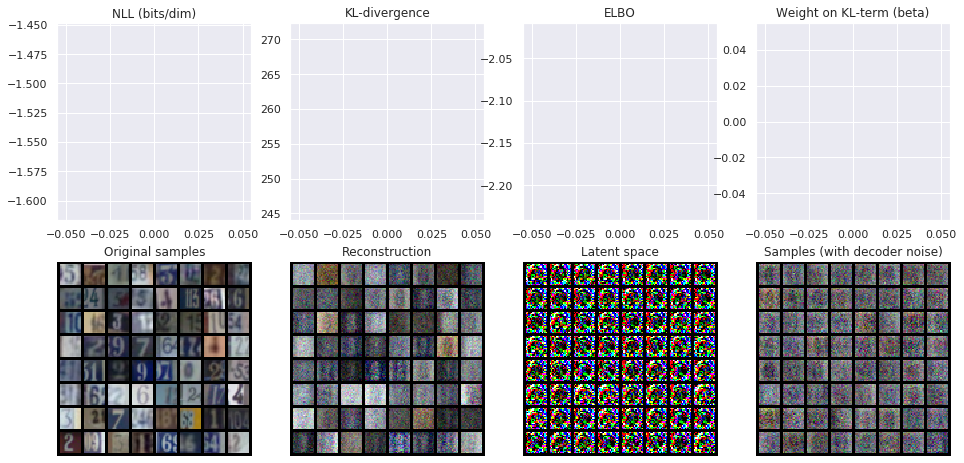




Epoch 2/50, ELBO: -0.6791435033101311, KL: 0.05260798973905868
Epoch 3/50, ELBO: -0.6880177850360782, KL: 0.0003010370475394745
Epoch 4/50, ELBO: -0.6885800044676497, KL: 0.0002499354334809401
Epoch 5/50, ELBO: -0.6873177755027865, KL: 0.00019540849064599188
Epoch 6/50, ELBO: -0.6866112887339032, KL: 0.00019970163673324606


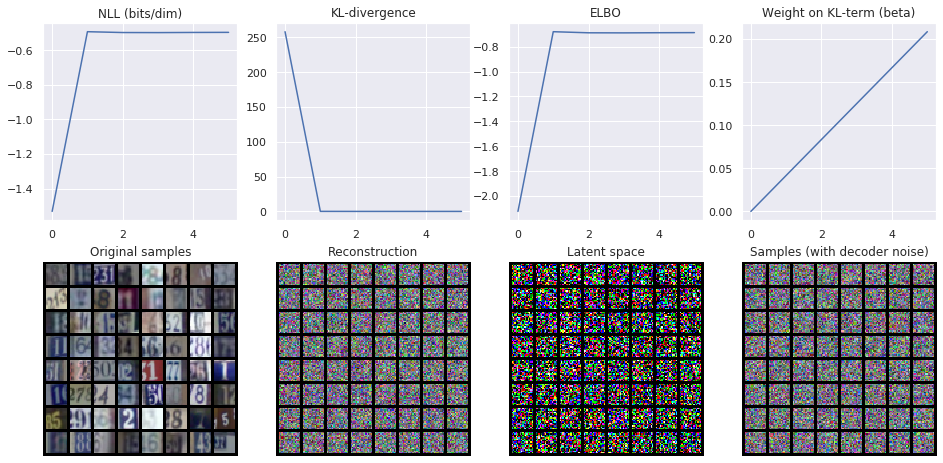




Epoch 7/50, ELBO: -0.6876087661735012, KL: 0.0001742276827860976
Epoch 8/50, ELBO: -0.6901394125154544, KL: 0.00022534354803909815
Epoch 9/50, ELBO: -0.6902141124082352, KL: 0.00018510861292304824
Epoch 10/50, ELBO: -0.6930709243630114, KL: 0.00016663474602481146
Epoch 11/50, ELBO: -0.6931931816120962, KL: 0.00020506273703927412


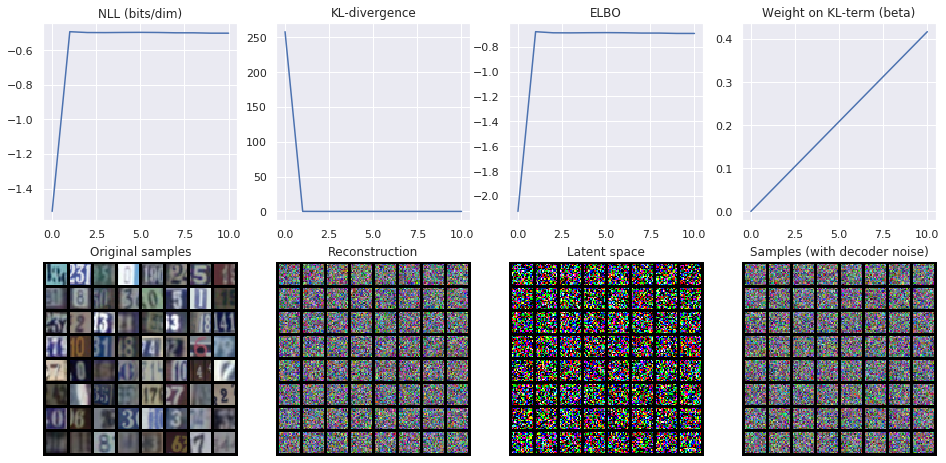




Epoch 12/50, ELBO: -0.6934445215322287, KL: 0.00016799421373663956
Epoch 13/50, ELBO: -0.6945993458828685, KL: 0.00017259379859959977
Epoch 14/50, ELBO: -0.6947603709020161, KL: 0.00017962487741706804
Epoch 15/50, ELBO: -0.6944209777367971, KL: 0.00019140563913481898
Epoch 16/50, ELBO: -0.6943199566730761, KL: 0.0001773173848488192


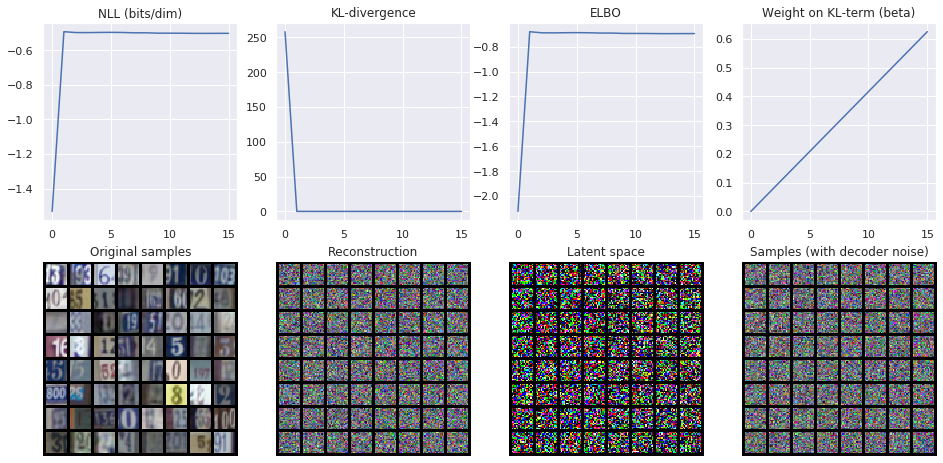




Epoch 17/50, ELBO: -0.6964875487854594, KL: 0.0001679178874451436
Epoch 18/50, ELBO: -0.6949830229396848, KL: 0.0001704846563988169
Epoch 19/50, ELBO: -0.6959760245676473, KL: 0.00017028837435109637
Epoch 20/50, ELBO: -0.6949792812776208, KL: 0.00017312979941320932
Epoch 21/50, ELBO: -0.6967021556919807, KL: 0.0001659286133362347


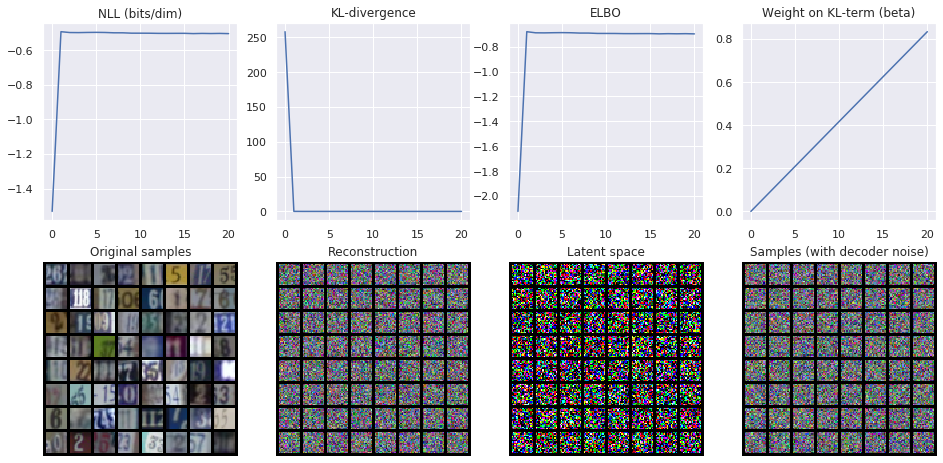




Epoch 22/50, ELBO: -0.6961249173713702, KL: 0.0001661799925624029
Epoch 23/50, ELBO: -0.6949497413768223, KL: 0.00019034255853735333
Epoch 24/50, ELBO: -0.6955408416435512, KL: 0.0001725925602189109
Epoch 25/50, ELBO: -0.6952557060560419, KL: 0.0001984762811376582
Epoch 26/50, ELBO: -0.6964467829084304, KL: 0.00021569151542825618


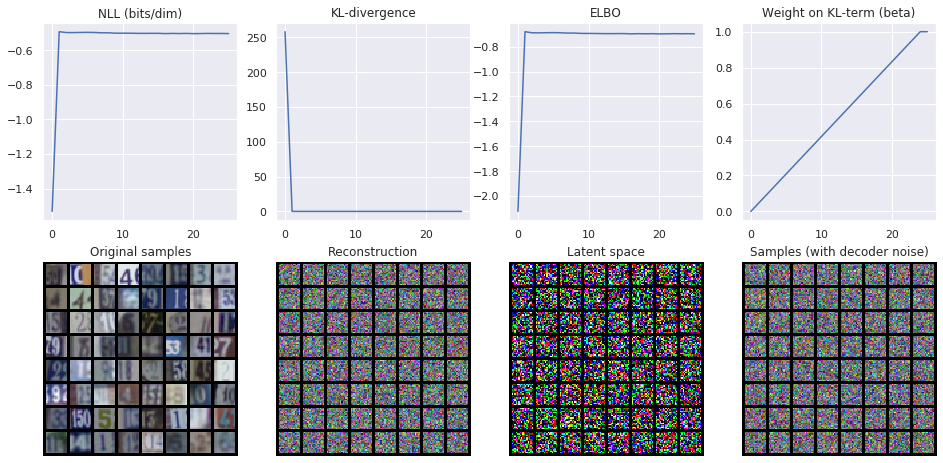




Epoch 27/50, ELBO: -0.6962966142162667, KL: 0.00017455111565820377
Epoch 28/50, ELBO: -0.6976366584070901, KL: 0.00015208111321878784
Epoch 29/50, ELBO: -0.6863356800180807, KL: 0.000257890658591089
Epoch 30/50, ELBO: -0.6941893771796638, KL: 0.00014996228987298216
Epoch 31/50, ELBO: -0.693360209609558, KL: 0.00015099619811472585


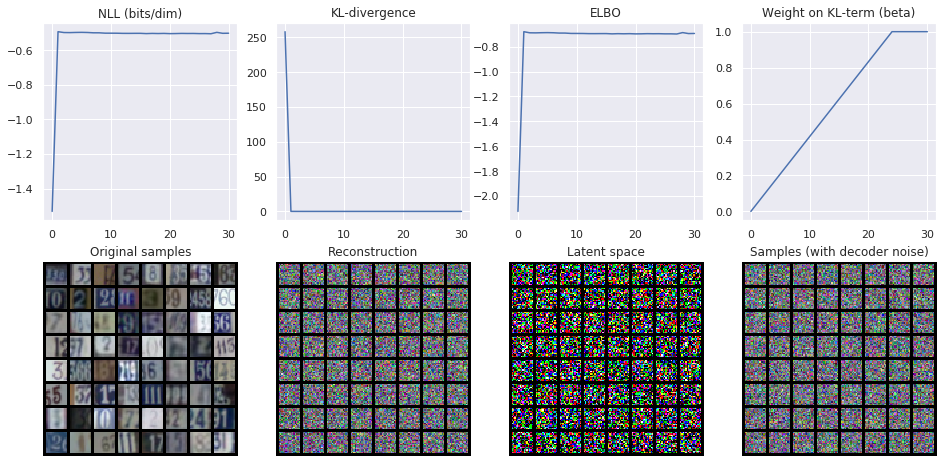




Epoch 32/50, ELBO: -0.6958270749920902, KL: 0.00015241660631174143
Epoch 33/50, ELBO: -0.6956555248752135, KL: 0.00016051492164639538
Epoch 34/50, ELBO: -0.6955379998360179, KL: 0.000153310965003322
Epoch 35/50, ELBO: -0.6956784725044678, KL: 0.00015714422390725335
Epoch 36/50, ELBO: -0.6954941956685887, KL: 0.000167177644206295


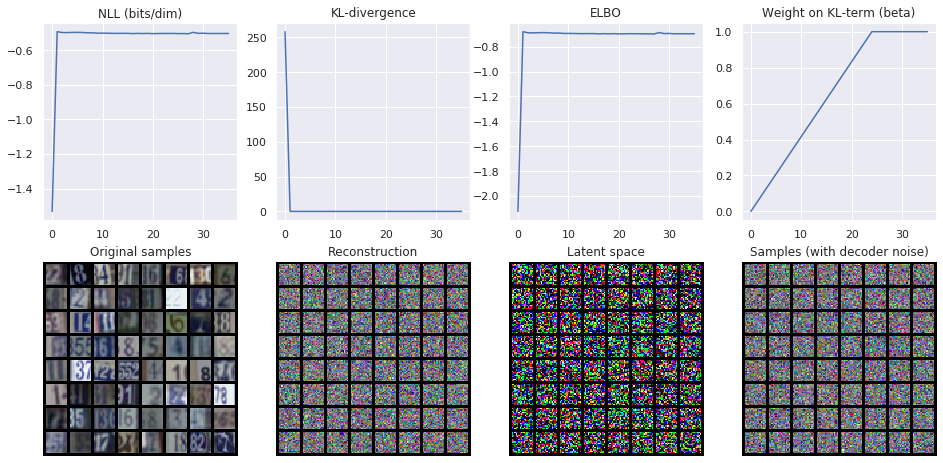




Epoch 37/50, ELBO: -0.695301372875847, KL: 0.00015865437919951463
Epoch 38/50, ELBO: -0.694247725498289, KL: 0.0001643369801486567
Epoch 39/50, ELBO: -0.6952619632158634, KL: 0.0001579294256904595
Epoch 40/50, ELBO: -0.6968635995190312, KL: 0.00016032853248747287
Epoch 41/50, ELBO: -0.695064865869301, KL: 0.0001610062593999784


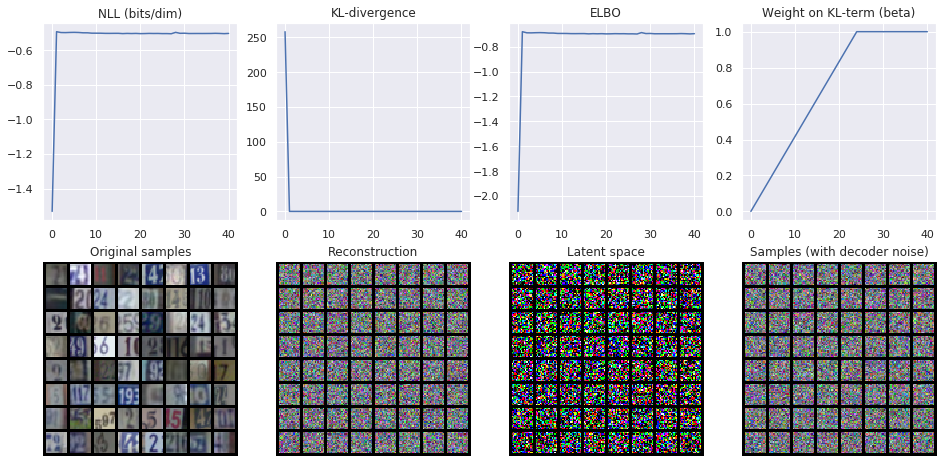




Epoch 42/50, ELBO: -0.6960726239285807, KL: 0.00015824646312990936
Epoch 43/50, ELBO: -0.6963808000752582, KL: 0.0001589609205584601
Epoch 44/50, ELBO: -0.6946151732646876, KL: 0.0001591110019902265
Epoch 45/50, ELBO: -0.6961320242207681, KL: 0.00016211608225939511
Epoch 46/50, ELBO: -0.695545833322981, KL: 0.00016144624712857104


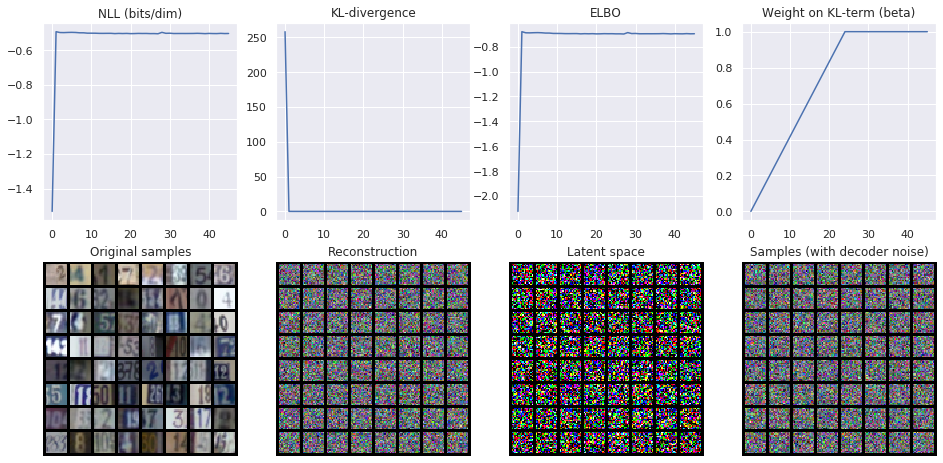




Epoch 47/50, ELBO: -0.6952306759181486, KL: 0.00016207583891665952
Epoch 48/50, ELBO: -0.696412555743316, KL: 0.0001641743174005683
Epoch 49/50, ELBO: -0.6963509195181609, KL: 0.0001576841422347632
Epoch 50/50, ELBO: -0.6974203492633124, KL: 0.0001569854892306138


In [11]:
def fit_img(dl_train, num_epochs=50):
  net = ImgVAE().cuda()
  optimizer = optim.Adam(net.parameters())
  schedule = BetaWarmup(num_epochs//2)

  train_elbo, valid_elbo = [], []
  train_nll, valid_nll = [], []
  train_kl, valid_kl = [], []

  for epoch in range(num_epochs):

    net.train()
    batch_elbo, batch_nll, batch_kl = [], [], []

    for x in dl_train:

      outputs = net(x)
      elbo, nll, kl = net.elbo(x, outputs, schedule[epoch])

      optimizer.zero_grad()
      elbo.backward()
      optimizer.step()
      
      batch_elbo.append(elbo.item())
      batch_nll.append(nll.item())
      batch_kl.append(kl.item())

    train_elbo.append(np.mean(batch_elbo))
    train_nll.append(np.mean(batch_nll))
    train_kl.append(np.mean(batch_kl))

    print(f'Epoch {epoch+1}/{num_epochs}, ELBO: {train_elbo[-1]}, KL: {train_kl[-1]}')

    if epoch % 5 == 0:
      evaluate_img(net, dl_val, (np.array(train_elbo), np.array(train_nll), np.array(train_kl)), schedule)

  return net, (np.array(train_elbo), np.array(train_nll), np.array(train_kl)), schedule


net, losses, schedule = fit_img(dl_train, num_epochs=50)